<a href="https://colab.research.google.com/github/shiv-2911/Anomaly-Detection-in-Satellite-Orbits/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import re
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

# Pre-defined Functions

##Importing Data Sets

In [2]:
def read_satellite_data(file_path, index_col=0, parse_dates=True):
  df = pd.read_csv(file_path, index_col=index_col, parse_dates=parse_dates)
  return df

In [3]:
#Function to extract start and endates from manoeuvre files.

def extract_start_end_dates(file_path):

  def extract_date(line, start):
    year = int(line[start:start+4])
    day_of_year = int(line[start+5:start+8])
    hour = int(line[start+9:start+11])
    minute = int(line[start+12:start+14])
    return pd.to_datetime(f"{year}-01-01") + pd.Timedelta(days=day_of_year-1, hours=hour, minutes=minute)

  data = []
  with open(file_path, 'r') as f:
    for line in f:
      start_date = extract_date(line, 6)
      end_date = extract_date(line, 21)
      data.append({'start_date': start_date, 'end_date': end_date})

  return pd.DataFrame(data)

## Formatting the columns

In [4]:
def format_cols(data):
  special_chars = r'[?|$|#|@|#|%|!|*|(|)|{|}|^|,|-|.|/|>|<|;|:]'
  # lower-case and replace any white-space '_' for every column name
  data.columns = list(map(lambda x:re.sub(special_chars,r'',x.lower().replace(' ','_').replace("'","").replace("|","_").replace('-','_')), data.columns))

## Checking for Duplicates

In [5]:
def check_duplicates(data):
  # collect duplicate using 'last'
  data_duplicate_avoid_one_val = data[data.duplicated(keep='last')]

  # collect all the duplicates
  data_duplicate_all = data[data.duplicated(keep=False)]

  # get unique count of duplicates
  len_data_duplicate_avoid_one_val = len(data_duplicate_avoid_one_val)
  len_data_duplicate_all = len(data_duplicate_all)
  count_unique_val_with_duplicates = len_data_duplicate_all - len_data_duplicate_avoid_one_val

  if count_unique_val_with_duplicates == 0:
    print("No duplicates")
  else:
    print("Duplicates are spotted")

## Missing Values

In [6]:
def missing_values(data):
   percent_msng_val = (data.isnull().sum().sum()/(data.shape[0]*data.shape[1]))*100
   print('Percentage of missing value in entire dataset is: {}%'.format(round(percent_msng_val,4)))

## ACF and PACF plots

In [7]:
def acf_pacf(data):
  variables = cs2_tle.columns
  num_vars = len(variables)

  fig, axes = plt.subplots(nrows=num_vars, ncols=2, figsize=(15, 3 * num_vars))

  for i, var in enumerate(variables):
    plot_acf(cs2_tle[var], ax=axes[i, 0], title=f'ACF of {var}')
    plot_pacf(cs2_tle[var], ax=axes[i, 1], title=f'PACF of {var}')

  plt.tight_layout()
  plt.show()

## Stationary Test: ADF Test

In [8]:
def adf_test_scores(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    print('')

def adf_test(data):
  for column in data.columns:
    adf_test_scores(data[column], title=column)

## Exploratory Data Analysis

In [9]:
def eda(data, man_data):
  # Display basic information about the dataset
  print(data.info())
  print(data.describe())
  # Plot time series charts for each variable as subplots in a single plot
  variables = data.columns
  num_vars = len(variables)

  fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, 2 * num_vars), sharex=True)
  legend_handles = [plt.plot([], [], color='r', linestyle='--', label='Manoeuvre Start Date')[0]]
  for i, var in enumerate(variables):
    axes[i].plot(data.index, data[var])
    axes[i].set_title(var)
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate date labels for better readability

    # Overlay start dates
    for start_date in man_data['start_date']:
        axes[i].axvline(x=start_date, color='r', linestyle='--', linewidth=0.8)

    axes[i].legend(handles=legend_handles)

  axes[-1].set_xlabel('Date')
  plt.tight_layout()
  plt.show()

## Exploratory Data Analysis Filtered

In [10]:
def eda_filtered(data, man_data, start, end):
  data = data[(data.index >= pd.Timestamp(start)) & (data.index < pd.Timestamp(end))]
  man_data = man_data[(man_data['start_date'] >= pd.Timestamp(start)) &(man_data['start_date'] < pd.Timestamp(end))]

  # Plot time series charts for each variable as subplots in a single plot
  variables = data.columns
  num_vars = len(variables)

  fig, axes = plt.subplots(nrows=num_vars, ncols=1, figsize=(10, 2 * num_vars), sharex=True)
  legend_handles = [plt.plot([], [], color='r', linestyle='--', label='Manoeuvre Start Date')[0]]
  for i, var in enumerate(variables):
    axes[i].plot(data.index, data[var])
    axes[i].set_title(var)
    axes[i].set_ylabel(var)
    axes[i].tick_params(axis='x', rotation=45)  # Rotate date labels for better readability

    # Overlay start dates
    for start_date in man_data['start_date']:
        axes[i].axvline(x=start_date, color='r', linestyle='--', linewidth=0.8)

    axes[i].legend(handles=legend_handles)

  axes[-1].set_xlabel('Date')
  plt.tight_layout()
  plt.show()

## ARIMA Model

In [11]:
def best_arima_fit(series):
  best_model = None
  best_mse = float('inf')
  best_order = None
  for p in range(1, 4):  # lags 1, 2, 3
      for d in range(0, 3):  # differencing 0, 1, 2
          for q in range(0, 3):  # MA terms 0, 1, 2
              try:
                  model = ARIMA(series, order=(p, d, q))
                  model_fit = model.fit()
                  residuals = model_fit.resid
                  mse = mean_squared_error(series[d:], residuals[d:])
                  if mse < best_mse:
                      best_mse = mse
                      best_model = model_fit
                      best_order = (p, d, q)
              except:
                  continue
  print(f'Best ARIMA order: {best_order} with MSE: {best_mse}')
  return best_model

## Plotting Residuals with Manoeuvre Timestamps

In [12]:
def plot_residuals(best_model, man_data, start, end):
  residuals = best_model.resid

  residuals = residuals[(residuals.index >= pd.Timestamp(start)) & (residuals.index < pd.Timestamp(end))]
  man_data = man_data[(man_data['start_date'] >= pd.Timestamp(start)) &(man_data['start_date'] < pd.Timestamp(end))]

  plt.figure(figsize=(12, 6))
  plt.plot(residuals, label='Residuals')
  plt.ylabel('Brower Mean Motion Residuals')
  plt.xlabel('Date')
  plt.title('Residuals Plot')

  for start_date in man_data['start_date']:
      plt.axvline(x=start_date, color='r', linestyle='--', linewidth=0.8)

  legend_handles = [plt.plot([], [], color='r', linestyle='--', label='Manoeuvre Start Date')[0]]
  plt.legend(handles=legend_handles)
  plt.show()

# CryoSat-2

## Importing Datasets

In [13]:
cs2_tle = read_satellite_data('unpropagated_elements_CryoSat-2.csv')
cs2_tle.head()

eccentricity  argument of perigee  inclination  \
2010-04-25 12:13:31.467936      0.001190             3.773156     1.606104   
2010-04-26 13:01:57.579456      0.001207             3.697660     1.606110   
2010-04-27 22:06:32.422176      0.001224             3.603564     1.606097   
2010-04-28 12:59:36.035519      0.001233             3.566036     1.606094   
2010-04-29 00:34:12.213407      0.001252             3.529150     1.606097   

                            mean anomaly  Brouwer mean motion  right ascension  
2010-04-25 12:13:31.467936     -3.772437             0.063403         5.077397  
2010-04-26 13:01:57.579456     -3.696826             0.063403         5.081760  
2010-04-27 22:06:32.422176     -3.602503             0.063403         5.087575  
2010-04-28 12:59:36.035519     -3.564917             0.063403         5.090192  
2010-04-29 00:34:12.213407     -3.527920             0.063403         5.092225

In [14]:
cs2man = extract_start_end_dates('cs2man.txt')
cs2man.head()

start_date            end_date
0 2010-04-15 17:47:00 2010-04-15 17:48:00
1 2010-05-03 17:55:00 2010-05-04 00:35:00
2 2010-05-04 18:38:00 2010-05-04 18:48:00
3 2010-05-05 17:44:00 2010-05-05 17:59:00
4 2010-05-06 18:26:00 2010-05-06 18:51:00

## Formatting the Columns

In [15]:
format_cols(cs2_tle)
cs2_tle.head()

eccentricity  argument_of_perigee  inclination  \
2010-04-25 12:13:31.467936      0.001190             3.773156     1.606104   
2010-04-26 13:01:57.579456      0.001207             3.697660     1.606110   
2010-04-27 22:06:32.422176      0.001224             3.603564     1.606097   
2010-04-28 12:59:36.035519      0.001233             3.566036     1.606094   
2010-04-29 00:34:12.213407      0.001252             3.529150     1.606097   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2010-04-25 12:13:31.467936     -3.772437             0.063403         5.077397  
2010-04-26 13:01:57.579456     -3.696826             0.063403         5.081760  
2010-04-27 22:06:32.422176     -3.602503             0.063403         5.087575  
2010-04-28 12:59:36.035519     -3.564917             0.063403         5.090192  
2010-04-29 00:34:12.213407     -3.527920             0.063403         5.092225

## Checking for Duplicates

In [16]:
check_duplicates(cs2_tle)

No duplicates


## Missing Values

In [17]:
missing_values(cs2_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

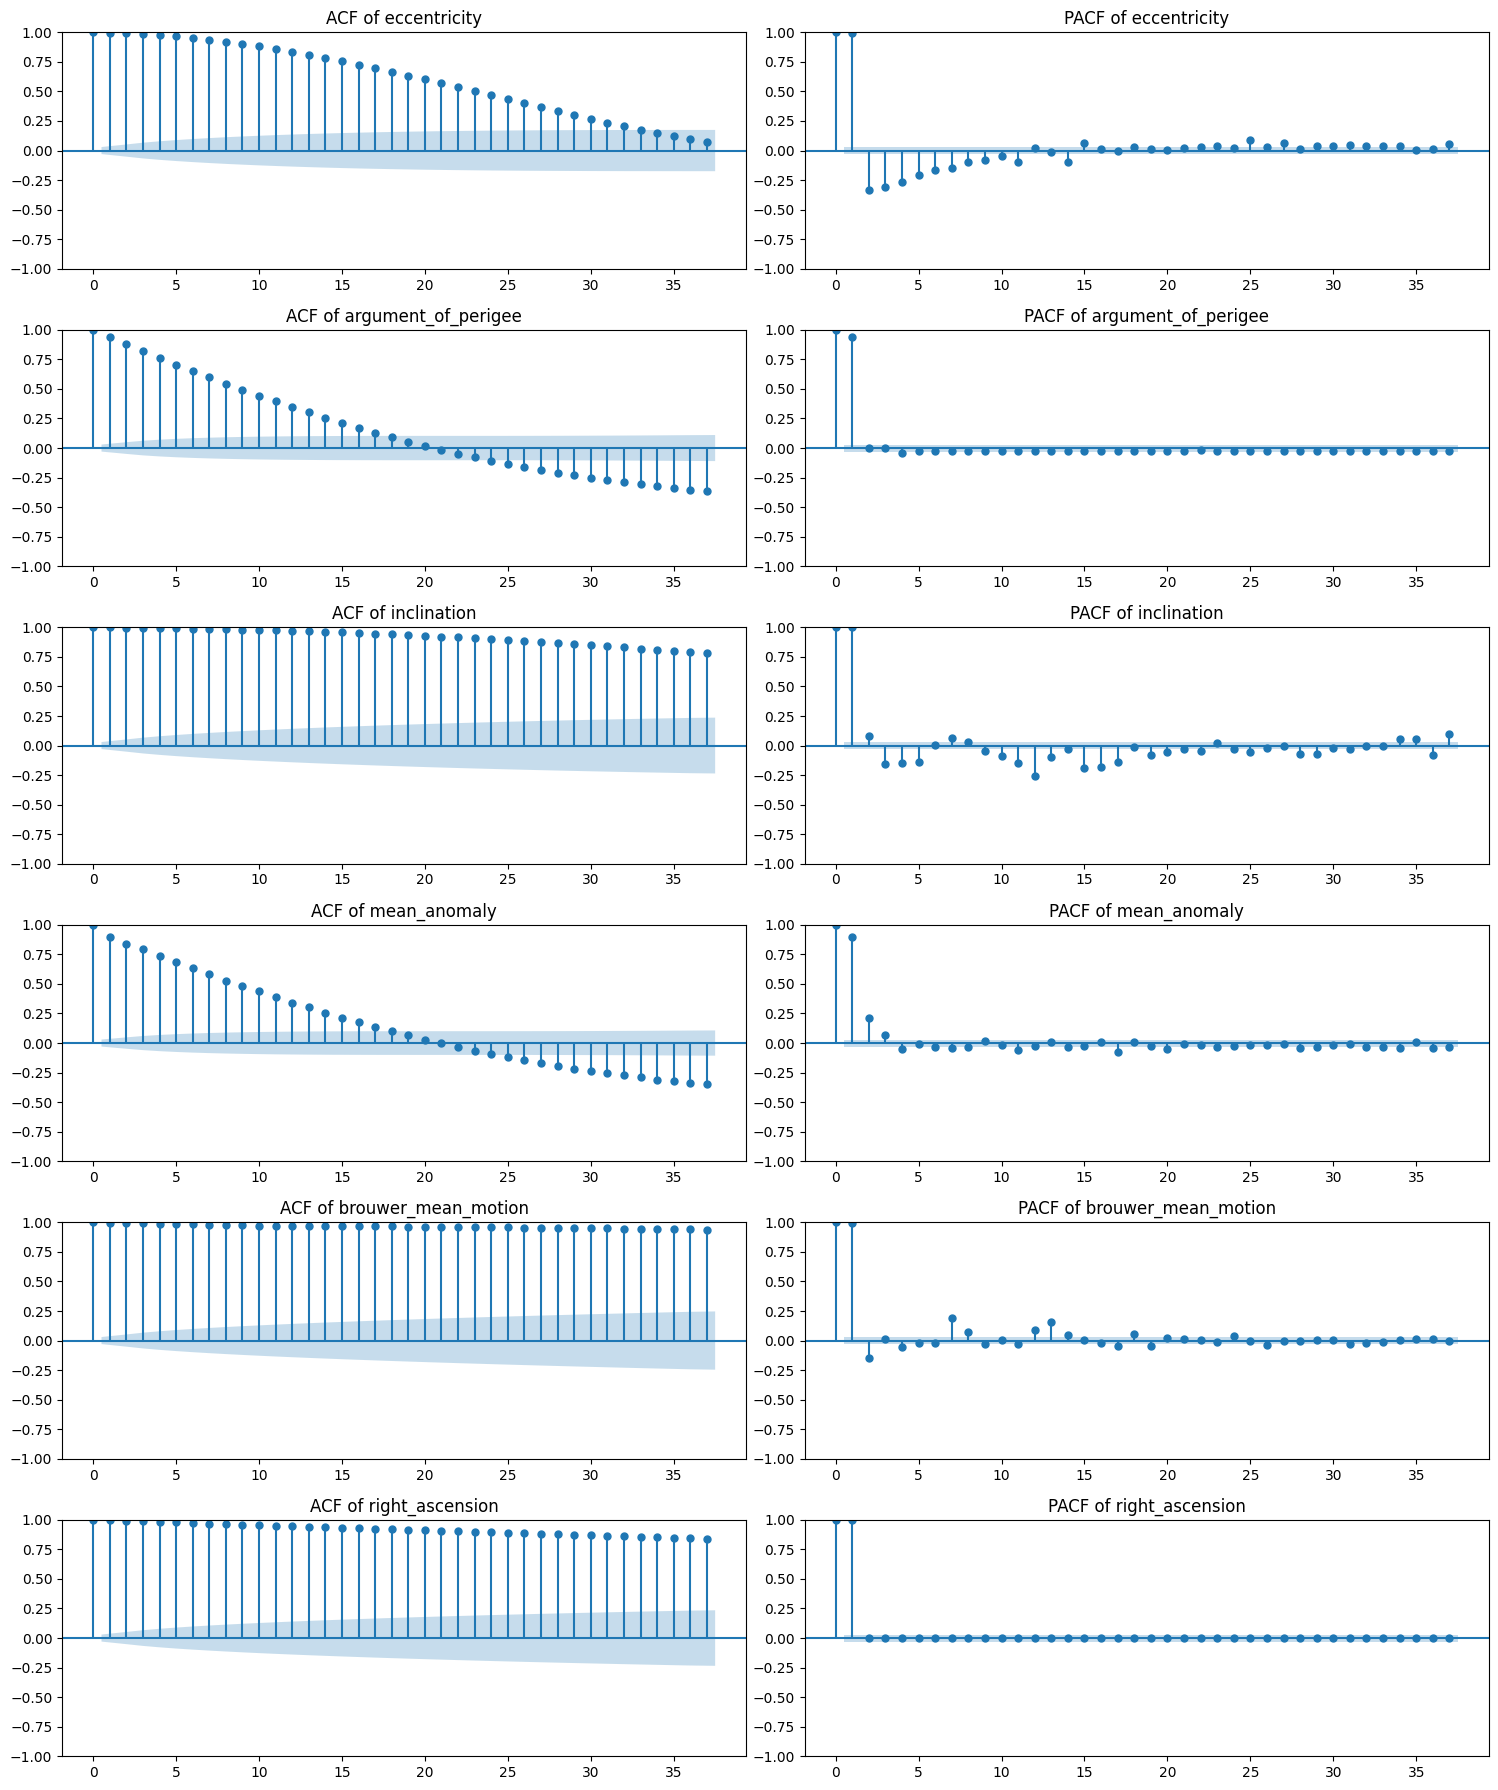

In [18]:
acf_pacf(cs2_tle)

## Stationary Test: ADF Test

In [19]:
adf_test(cs2_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic               -4.149340
p-value                           0.000802
#Lags Used                       29.000000
Number of Observations Used    4278.000000
Critical Value (1%)              -3.431880
Critical Value (5%)              -2.862216
Critical Value (10%)             -2.567130

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -1.340420e+01
p-value                        4.503985e-25
#Lags Used                     3.100000e+01
Number of Observations Used    4.276000e+03
Critical Value (1%)           -3.431880e+00
Critical Value (5%)           -2.862216e+00
Critical Value (10%)          -2.567130e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic            -1.132975e+01
p-value                        1.120330e-20
#Lags Used                     3.000000e+01
Number of Observations Used    4.277000e+03
Critical Value (1%)           -3.431880e+00
Critical Value (5%)           -2.8

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4308 entries, 2010-04-25 12:13:31.467936 to 2022-09-28 13:32:45.927743
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         4308 non-null   float64
 1   argument_of_perigee  4308 non-null   float64
 2   inclination          4308 non-null   float64
 3   mean_anomaly         4308 non-null   float64
 4   brouwer_mean_motion  4308 non-null   float64
 5   right_ascension      4308 non-null   float64
dtypes: float64(6)
memory usage: 235.6 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   4308.000000          4308.000000  4308.000000   4308.000000   
mean       0.000823             2.812684     1.606134     -2.818992   
std        0.000233             1.789181     0.000105      1.806961   
min        0.000224             0.003416     1.605876     -6.279445   
25%        0.000650             1.310100  

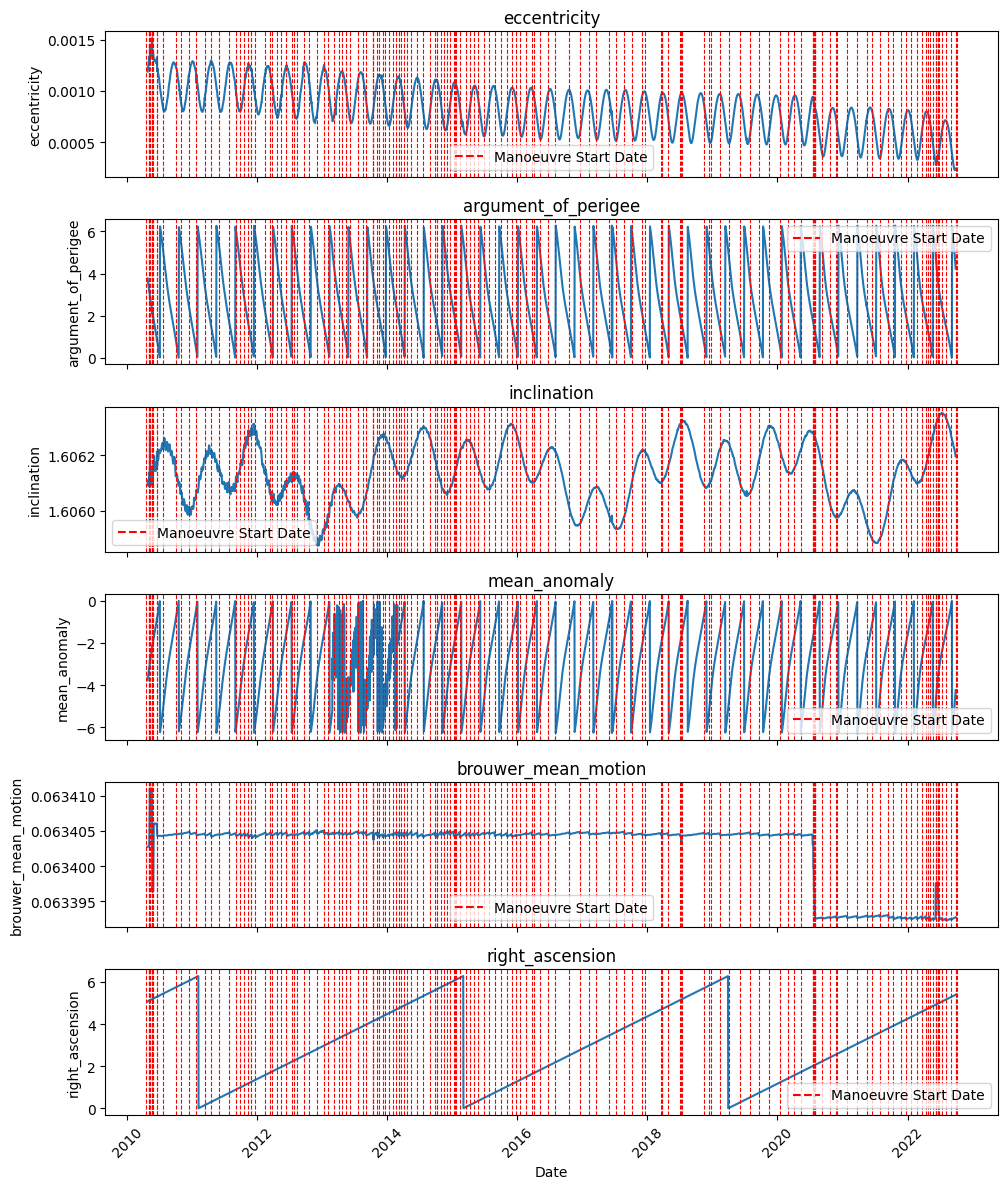

In [20]:
eda(cs2_tle, cs2man)

## Exploratory Data Analysis Filtered

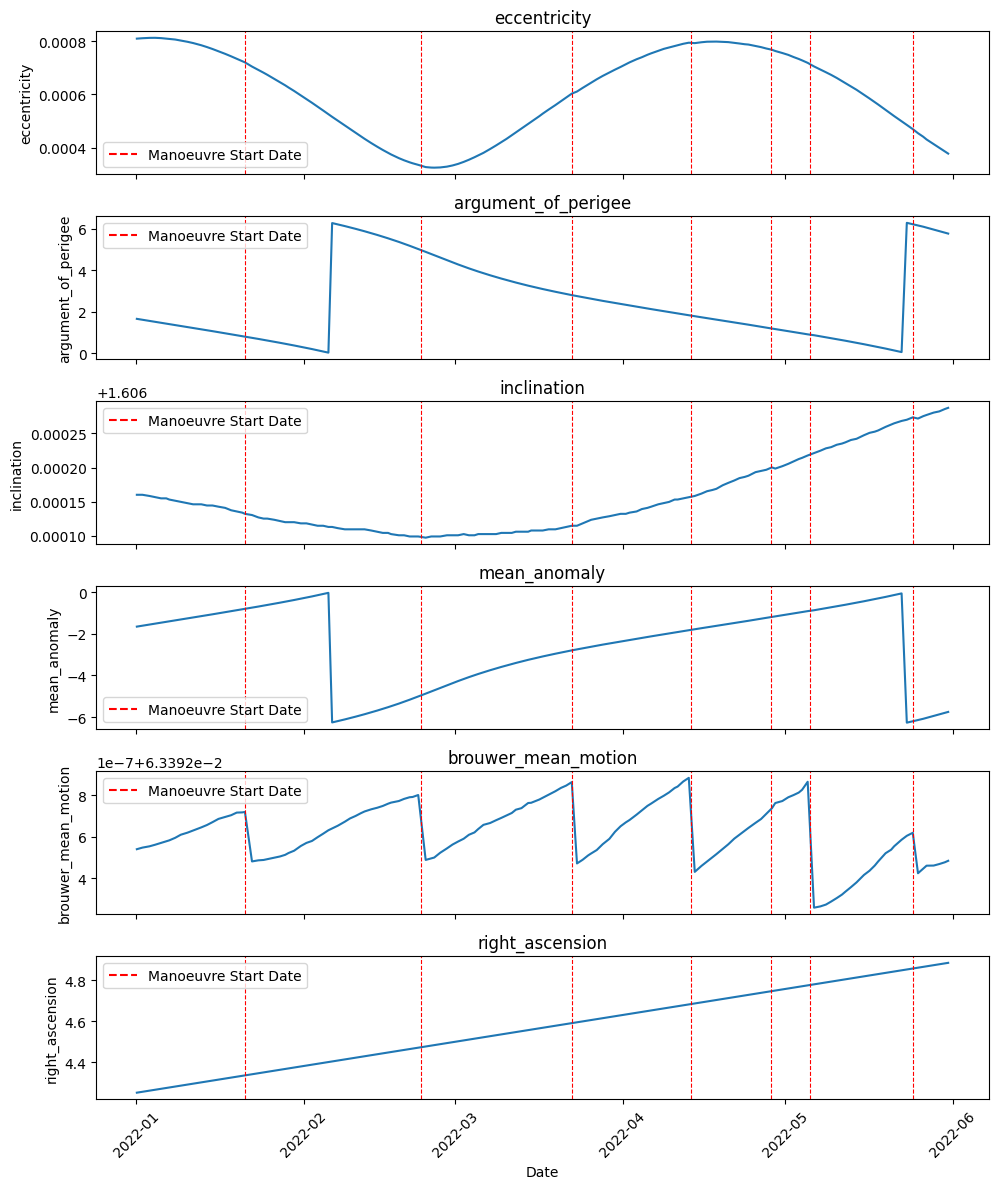

In [21]:
eda_filtered(cs2_tle, cs2man, '2022-01-01', '2022-06-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (3, 0, 2) with MSE: 6.692662062389892e-07


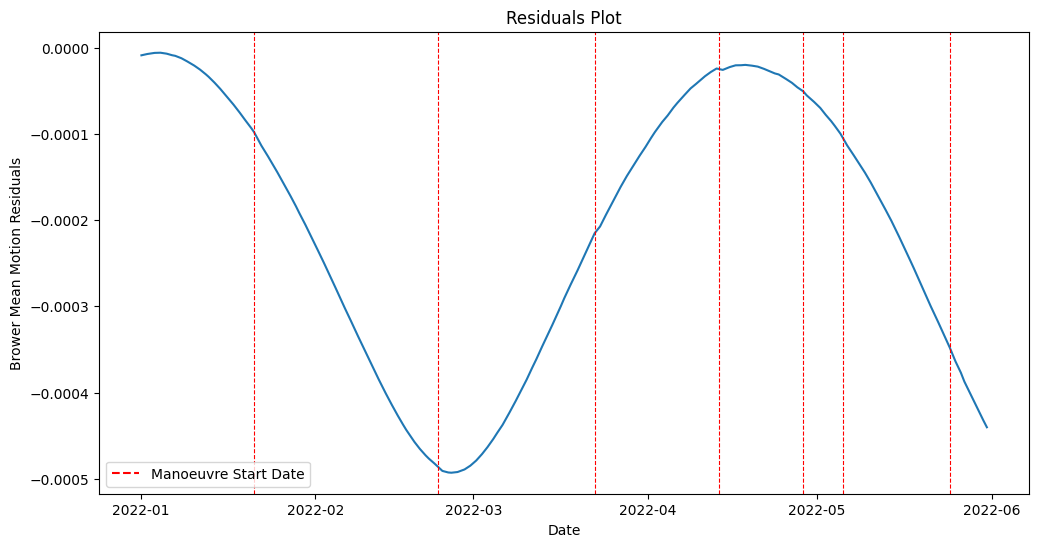

In [22]:
cs2ecc_best_model = best_arima_fit(cs2_tle['eccentricity'])

plot_residuals(cs2ecc_best_model,cs2man, '2022-01-01', '2022-06-01')

### Argument of Perigee

Best ARIMA order: (3, 1, 2) with MSE: 10.71112016275884


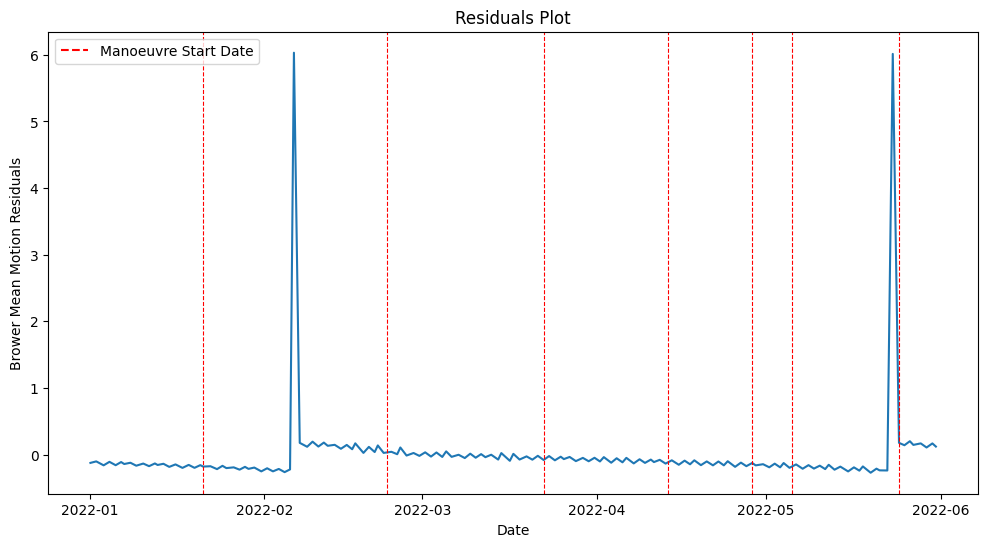

In [23]:
cs2aop_best_model = best_arima_fit(cs2_tle['argument_of_perigee'])

plot_residuals(cs2aop_best_model,cs2man, '2022-01-01', '2022-06-01')

### Inclination

Best ARIMA order: (3, 0, 2) with MSE: 2.5791100223748633


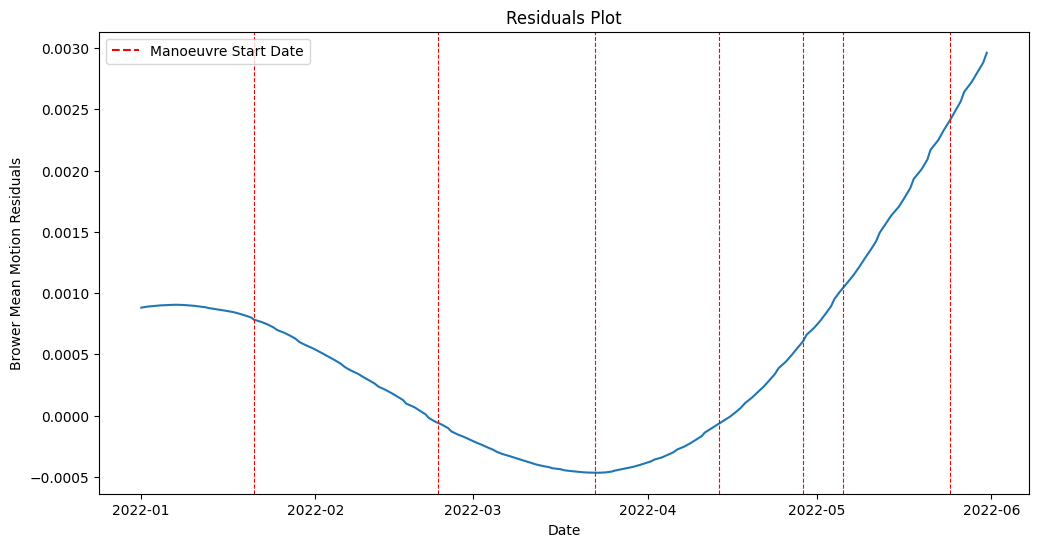

In [24]:
cs2inc_best_model = best_arima_fit(cs2_tle['inclination'])

plot_residuals(cs2inc_best_model,cs2man, '2022-01-01', '2022-06-01')

### Mean Anomaly

Best ARIMA order: (1, 0, 0) with MSE: 10.55213158188041


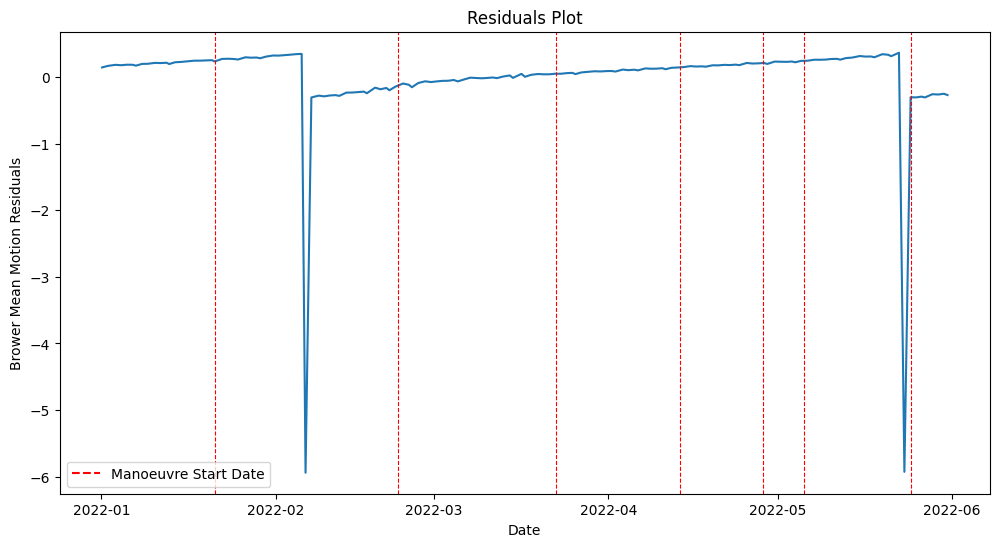

In [25]:
cs2ma_best_model = best_arima_fit(cs2_tle['mean_anomaly'])

plot_residuals(cs2ma_best_model,cs2man, '2022-01-01', '2022-06-01')

### Brouwer Mean Motion

Best ARIMA order: (2, 2, 2) with MSE: 0.004019860111543771


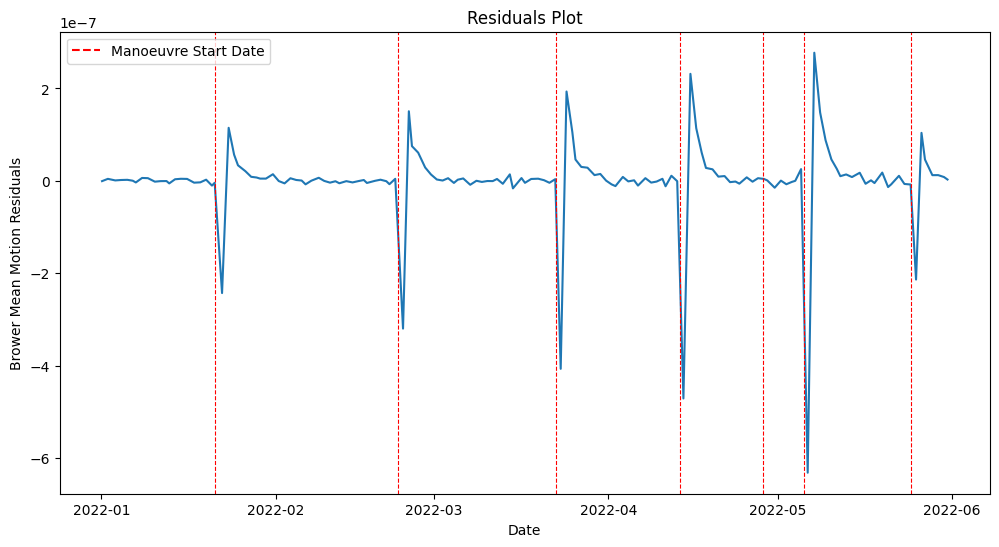

In [26]:
cs2bmm_best_model = best_arima_fit(cs2_tle['brouwer_mean_motion'])

plot_residuals(cs2bmm_best_model,cs2man, '2022-01-01', '2022-06-01')

### Right Ascension

Best ARIMA order: (1, 0, 2) with MSE: 13.143844952025526


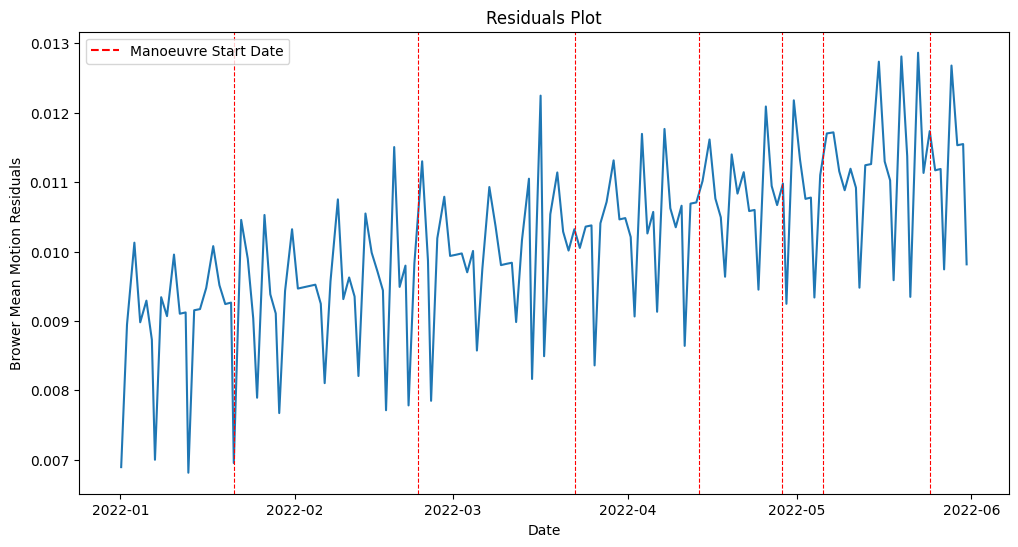

In [27]:
cs2ra_best_model = best_arima_fit(cs2_tle['right_ascension'])

plot_residuals(cs2ra_best_model,cs2man, '2022-01-01', '2022-06-01')

# Haiyang-2A

## Importing Datasets

In [28]:
h2a_tle = read_satellite_data('unpropagated_elements_Haiyang-2A.csv')
h2a_tle.head()

eccentricity  argument of perigee  inclination  \
2011-10-08 03:08:31.065504      0.000158             1.456236     1.734299   
2011-10-09 01:46:27.454367      0.000158             1.412851     1.734299   
2011-10-10 03:53:18.699936      0.000149             1.414537     1.734285   
2011-10-11 02:31:15.109536      0.000147             1.360987     1.734292   
2011-10-12 02:53:38.975135      0.000150             1.457867     1.734280   

                            mean anomaly  Brouwer mean motion  right ascension  
2011-10-08 03:08:31.065504     -1.453913             0.060217         5.018305  
2011-10-09 01:46:27.454367     -1.410530             0.060217         5.034573  
2011-10-10 03:53:18.699936     -1.412231             0.060217         5.053360  
2011-10-11 02:31:15.109536     -1.358690             0.060217         5.069649  
2011-10-12 02:53:38.975135     -1.455514             0.060217         5.087160

In [29]:
h2aman = extract_start_end_dates('h2aman.txt')
h2aman.head()

start_date            end_date
0 2011-09-28 16:20:00 2011-09-28 16:20:00
1 2012-02-14 03:05:00 2012-02-14 03:05:00
2 2012-02-24 03:20:00 2012-02-24 03:20:00
3 2012-04-20 03:20:00 2012-04-20 03:20:00
4 2012-06-08 02:35:00 2012-06-08 02:35:00

## Formatting the Columns

In [30]:
format_cols(h2a_tle)
h2a_tle.head()

eccentricity  argument_of_perigee  inclination  \
2011-10-08 03:08:31.065504      0.000158             1.456236     1.734299   
2011-10-09 01:46:27.454367      0.000158             1.412851     1.734299   
2011-10-10 03:53:18.699936      0.000149             1.414537     1.734285   
2011-10-11 02:31:15.109536      0.000147             1.360987     1.734292   
2011-10-12 02:53:38.975135      0.000150             1.457867     1.734280   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2011-10-08 03:08:31.065504     -1.453913             0.060217         5.018305  
2011-10-09 01:46:27.454367     -1.410530             0.060217         5.034573  
2011-10-10 03:53:18.699936     -1.412231             0.060217         5.053360  
2011-10-11 02:31:15.109536     -1.358690             0.060217         5.069649  
2011-10-12 02:53:38.975135     -1.455514             0.060217         5.087160

## Checking for Duplicates

In [31]:
check_duplicates(h2a_tle)

No duplicates


## Missing Values

In [32]:
missing_values(h2a_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

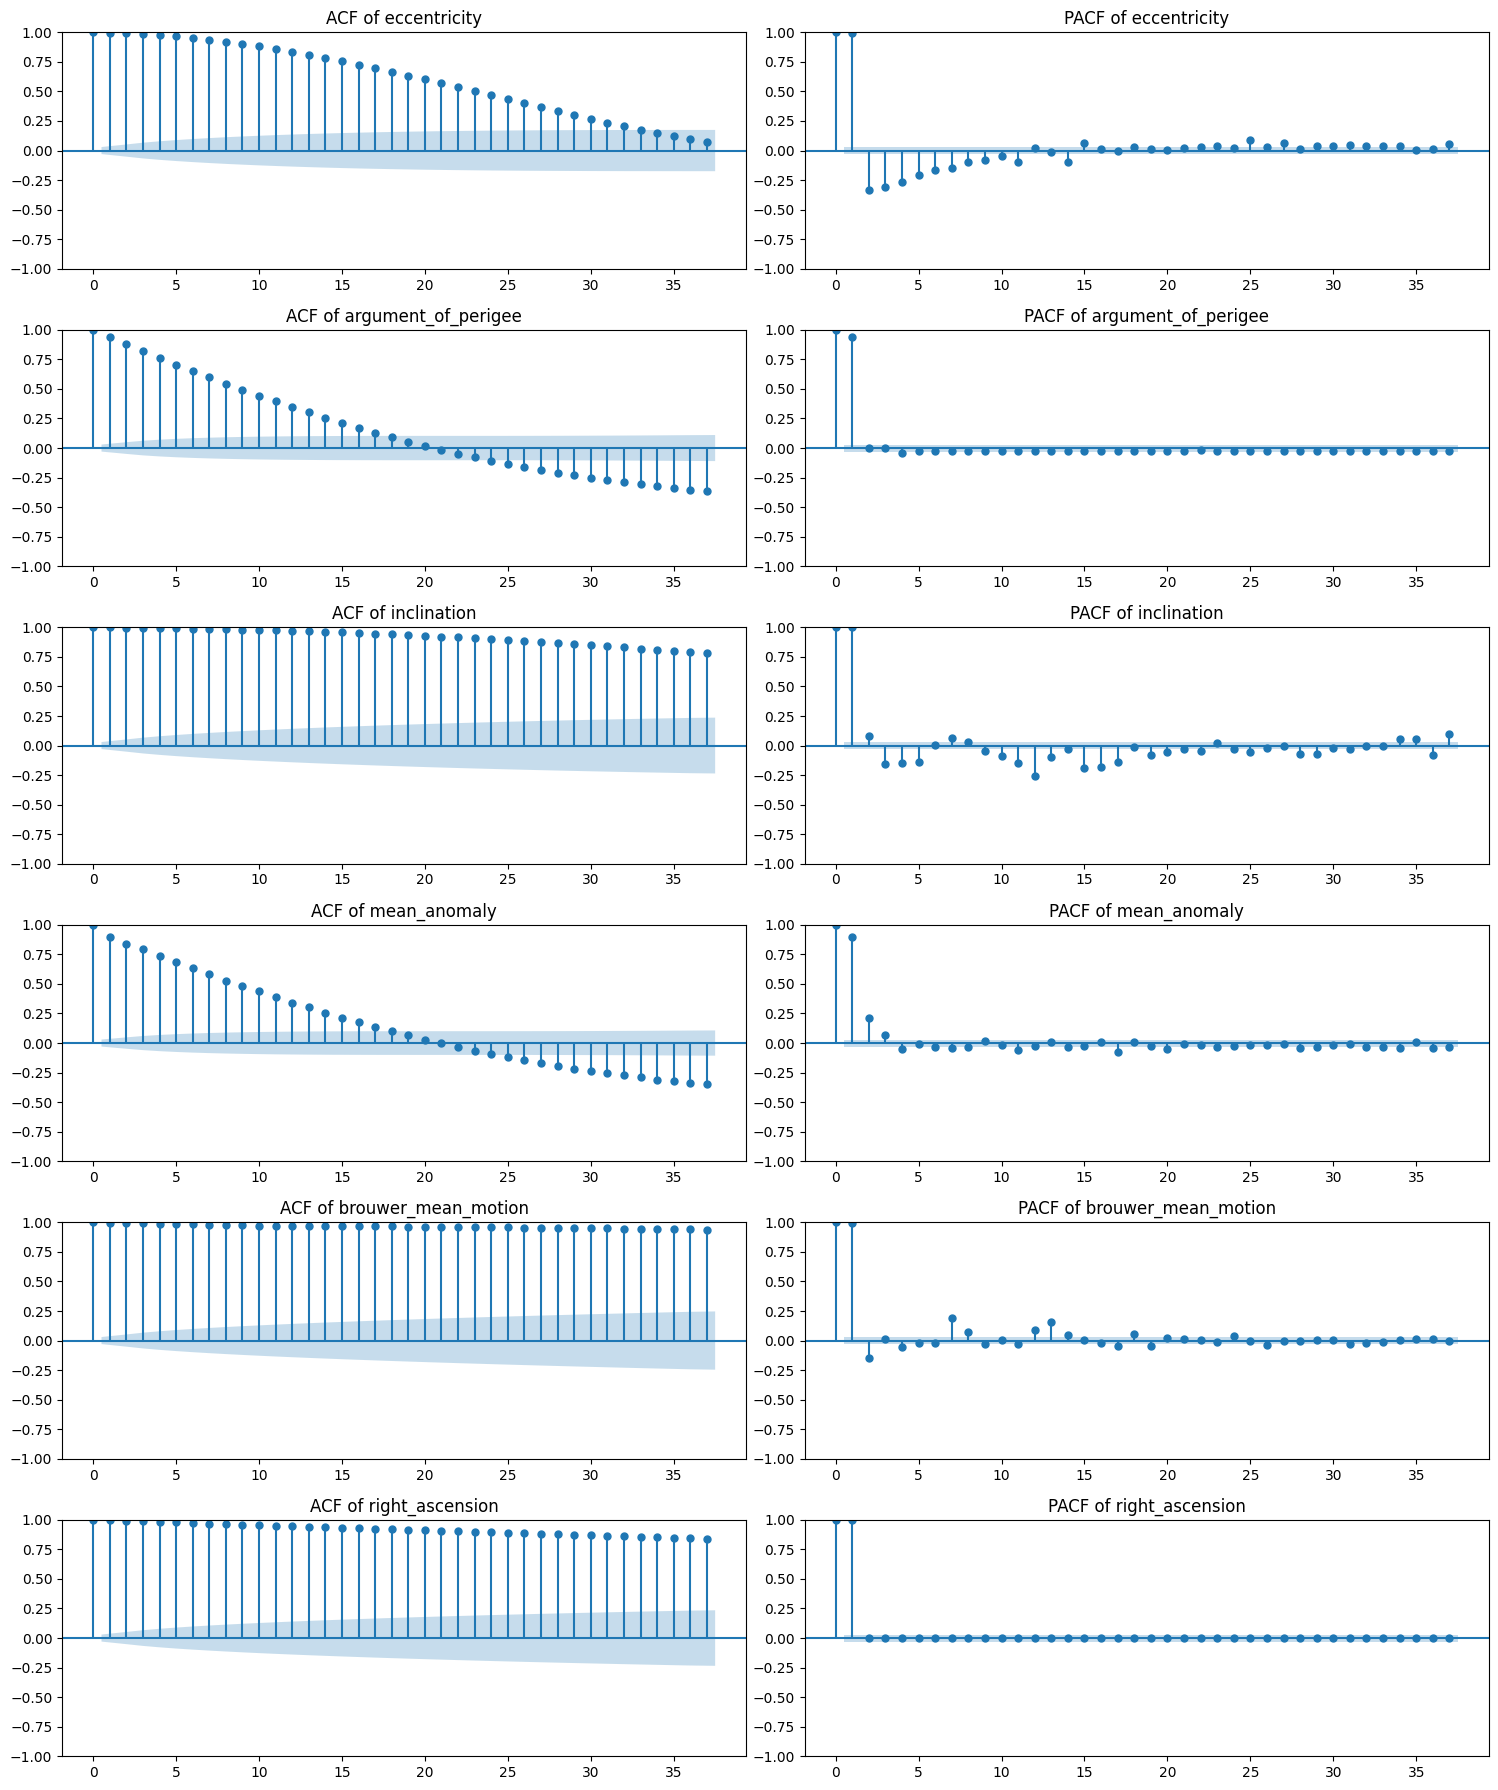

In [33]:
acf_pacf(h2a_tle)

## Stationary Test: ADF Test

In [34]:
adf_test(h2a_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -1.197919e+01
p-value                        3.739411e-22
#Lags Used                     2.900000e+01
Number of Observations Used    2.968000e+03
Critical Value (1%)           -3.432555e+00
Critical Value (5%)           -2.862514e+00
Critical Value (10%)          -2.567289e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -9.278674e+00
p-value                        1.268450e-15
#Lags Used                     2.800000e+01
Number of Observations Used    2.969000e+03
Critical Value (1%)           -3.432554e+00
Critical Value (5%)           -2.862514e+00
Critical Value (10%)          -2.567288e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic               -0.252252
p-value                           0.932000
#Lags Used                       19.000000
Number of Observations Used    2978.000000
Critical Value (1%)              -3.432548
Critical Value (5%)             

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2998 entries, 2011-10-08 03:08:31.065504 to 2020-06-02 01:53:24.932255
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         2998 non-null   float64
 1   argument_of_perigee  2998 non-null   float64
 2   inclination          2998 non-null   float64
 3   mean_anomaly         2998 non-null   float64
 4   brouwer_mean_motion  2998 non-null   float64
 5   right_ascension      2998 non-null   float64
dtypes: float64(6)
memory usage: 164.0 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   2998.000000          2998.000000  2998.000000   2998.000000   
mean       0.000118             1.562484     1.733842     -1.566304   
std        0.000058             0.806231     0.000276      0.822871   
min        0.000002             0.014502     1.733355     -6.256930   
25%        0.000073             0.999030  

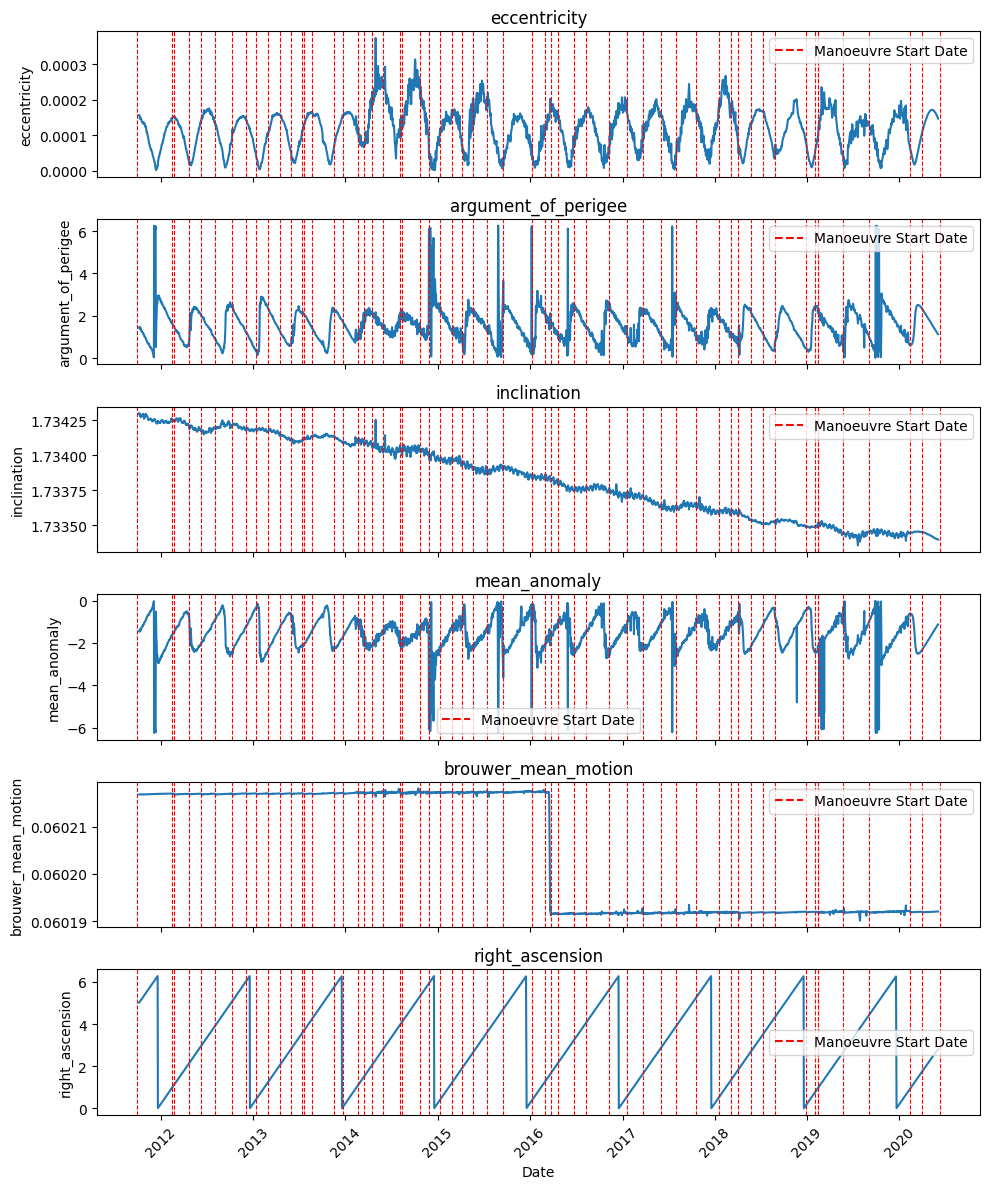

In [35]:
eda(h2a_tle, h2aman)

## Exploratory Data Analysis Filtered

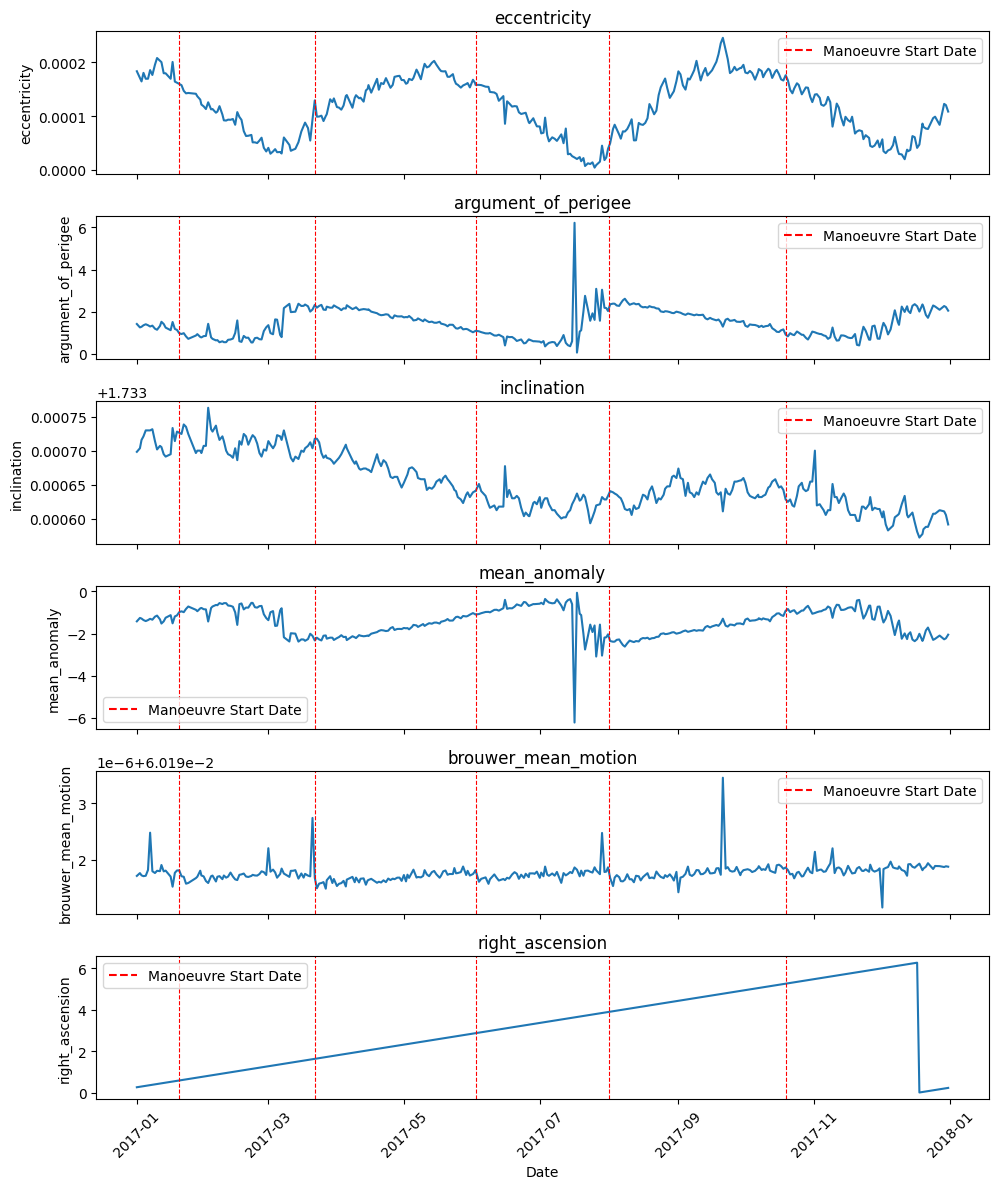

In [36]:
eda_filtered(h2a_tle, h2aman, '2017-01-01', '2018-01-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

In [37]:
h2aecc_best_model = best_arima_fit(h2a_tle['eccentricity'])

Best ARIMA order: (1, 1, 1) with MSE: 1.6943796943697413e-08


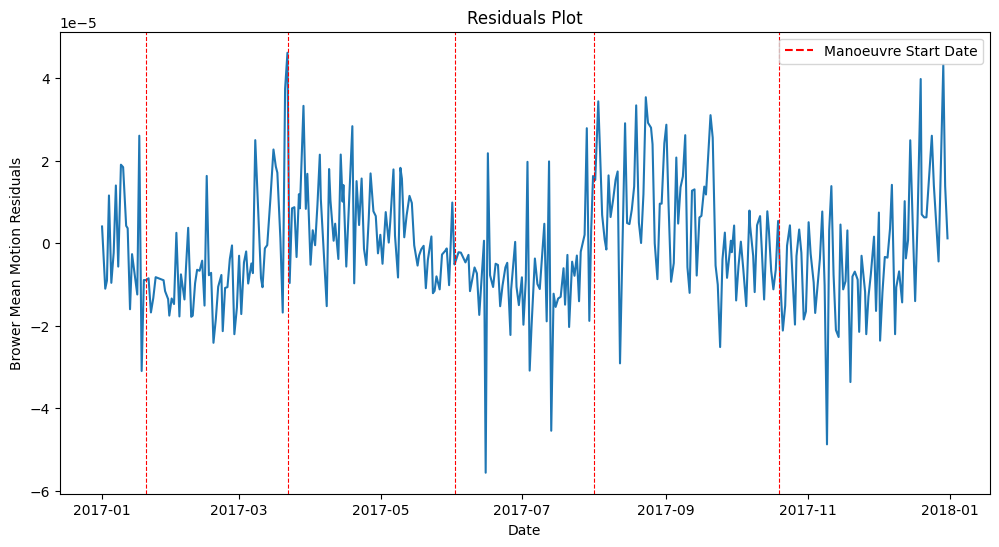

In [94]:
plot_residuals(h2aecc_best_model,h2aman, '2017-01-01', '2018-01-01')

### Argument of Perigee

In [39]:
h2aaop_best_model = best_arima_fit(h2a_tle['argument_of_perigee'])

Best ARIMA order: (1, 0, 0) with MSE: 2.8637679238110127


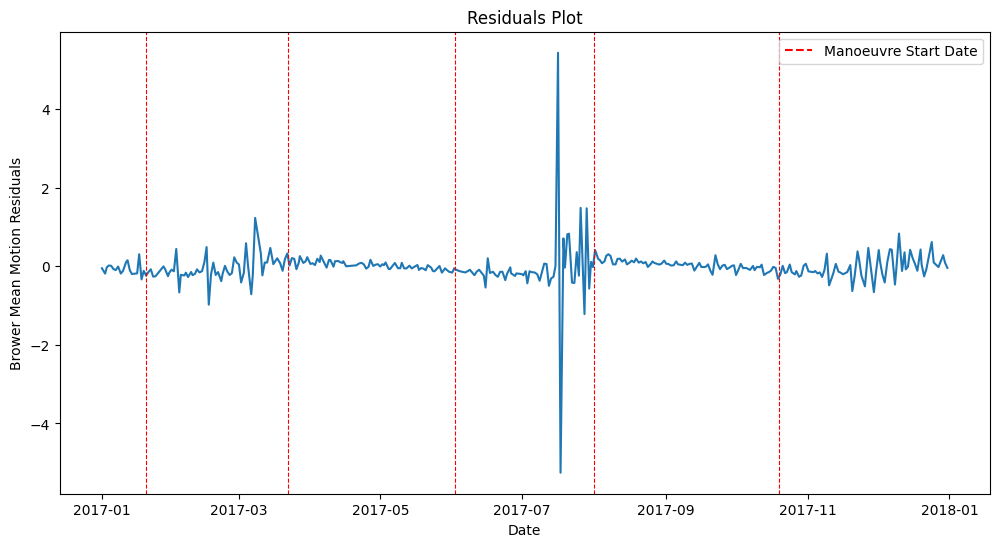

In [95]:
plot_residuals(h2aaop_best_model,h2aman, '2017-01-01', '2018-01-01')

### Inclination

In [41]:
h2ainc_best_model = best_arima_fit(h2a_tle['inclination'])

Best ARIMA order: (2, 2, 2) with MSE: 3.0062066003545453


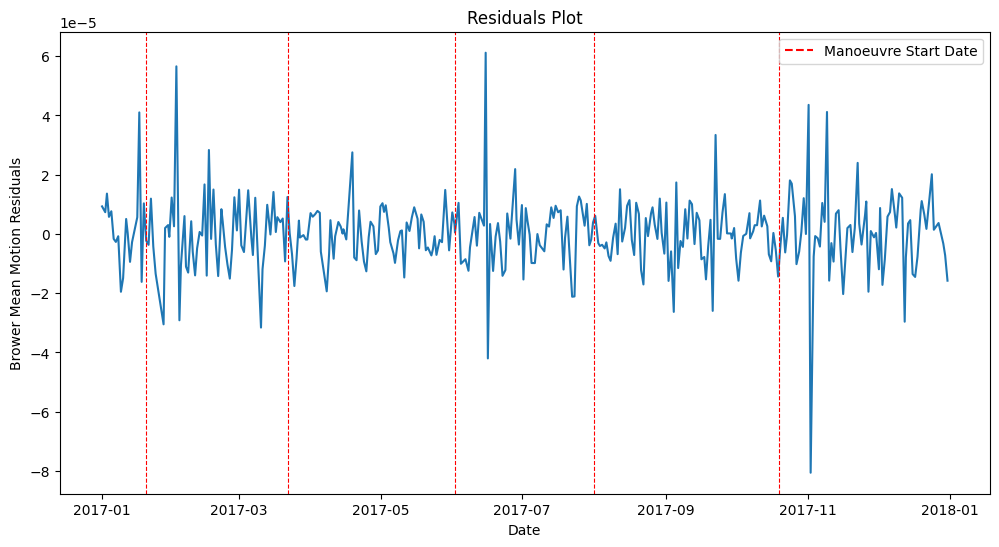

In [96]:
plot_residuals(h2ainc_best_model,h2aman, '2017-01-01', '2018-01-01')

### Mean Anomaly

In [43]:
h2ama_best_model = best_arima_fit(h2a_tle['mean_anomaly'])

Best ARIMA order: (1, 0, 0) with MSE: 2.8635999507133434


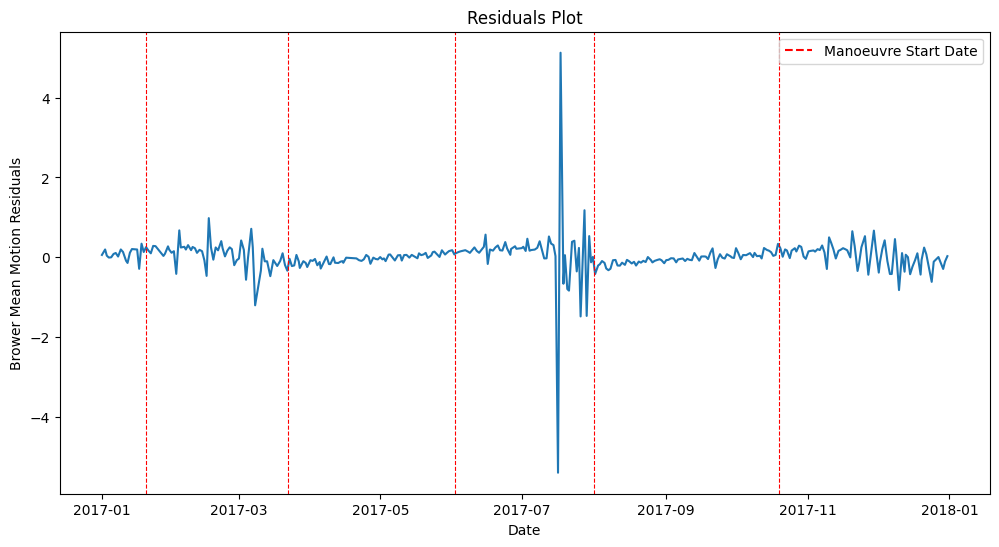

In [97]:
plot_residuals(h2ama_best_model,h2aman, '2017-01-01', '2018-01-01')

### Brouwer Mean Motion

In [45]:
h2abmm_best_model = best_arima_fit(h2a_tle['brouwer_mean_motion'])

Best ARIMA order: (2, 2, 0) with MSE: 0.0036246467624824236


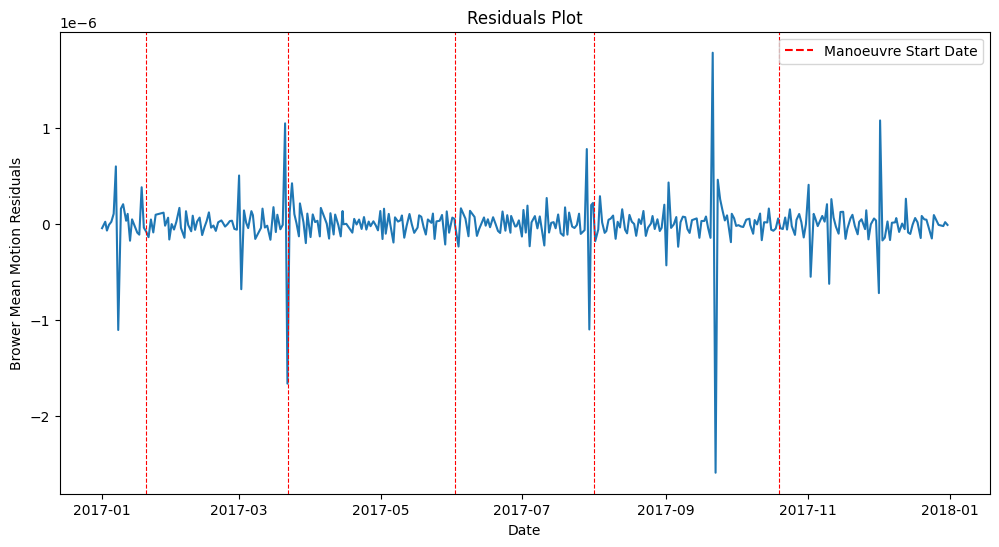

In [98]:
plot_residuals(h2abmm_best_model,h2aman, '2017-01-01', '2018-01-01')

### Right Ascension

In [47]:
h2ara_best_model = best_arima_fit(h2a_tle['right_ascension'])

Best ARIMA order: (1, 0, 2) with MSE: 12.790177039790416


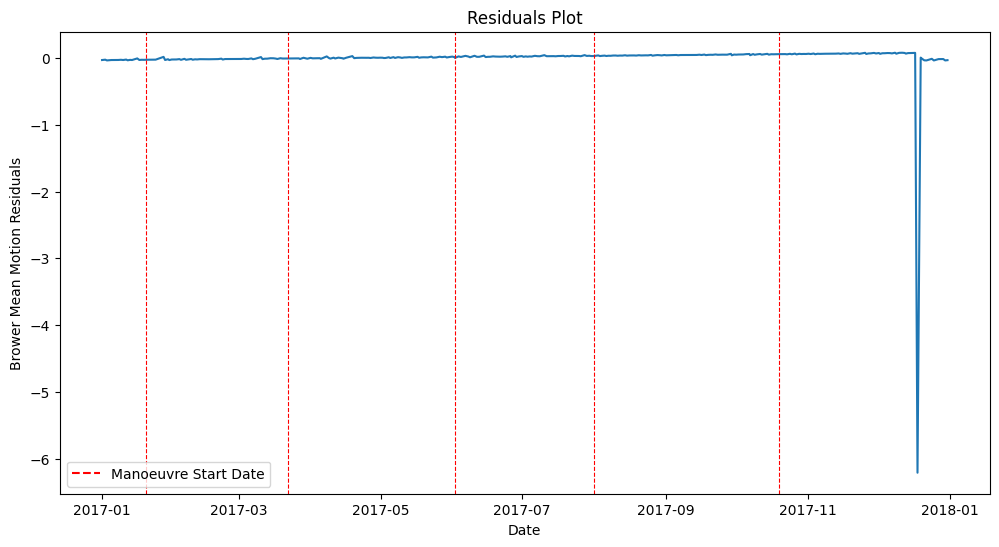

In [99]:
plot_residuals(h2ara_best_model,h2aman, '2017-01-01', '2018-01-01')

# Jason-3

## Importing Datasets

In [49]:
ja3_tle = read_satellite_data('unpropagated_elements_Jason-3.csv')
ja3_tle.head()

eccentricity  argument of perigee  inclination  \
2016-01-31 19:27:29.355551      0.000817             4.697711     1.152607   
2016-02-04 19:09:58.974336      0.000544             4.925965     1.152636   
2016-02-05 17:43:49.867103      0.000803             4.672899     1.152678   
2016-02-06 01:14:32.477856      0.000804             4.673404     1.152675   
2016-02-07 01:39:21.000384      0.000807             4.692616     1.152684   

                            mean anomaly  Brouwer mean motion  right ascension  
2016-01-31 19:27:29.355551     -5.138166             0.056076         1.493000  
2016-02-04 19:09:58.974336     -4.924886             0.055859         1.348476  
2016-02-05 17:43:49.867103     -4.672712             0.055784         1.314673  
2016-02-06 01:14:32.477856     -4.673201             0.055784         1.303398  
2016-02-07 01:39:21.000384     -4.692489             0.055784         1.266706

In [50]:
ja3man = extract_start_end_dates('ja3man.txt')
ja3man.head()

start_date            end_date
0 2016-01-19 22:18:00 2016-01-20 01:06:00
1 2016-01-21 22:39:00 2016-01-22 01:28:00
2 2016-01-28 22:45:00 2016-01-29 02:05:00
3 2016-01-31 21:38:00 2016-02-01 00:32:00
4 2016-02-02 03:35:00 2016-02-02 06:30:00

## Formatting the Columns

In [51]:
format_cols(ja3_tle)
ja3_tle.head()

eccentricity  argument_of_perigee  inclination  \
2016-01-31 19:27:29.355551      0.000817             4.697711     1.152607   
2016-02-04 19:09:58.974336      0.000544             4.925965     1.152636   
2016-02-05 17:43:49.867103      0.000803             4.672899     1.152678   
2016-02-06 01:14:32.477856      0.000804             4.673404     1.152675   
2016-02-07 01:39:21.000384      0.000807             4.692616     1.152684   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2016-01-31 19:27:29.355551     -5.138166             0.056076         1.493000  
2016-02-04 19:09:58.974336     -4.924886             0.055859         1.348476  
2016-02-05 17:43:49.867103     -4.672712             0.055784         1.314673  
2016-02-06 01:14:32.477856     -4.673201             0.055784         1.303398  
2016-02-07 01:39:21.000384     -4.692489             0.055784         1.266706

## Checking for Duplicates

In [52]:
check_duplicates(ja3_tle)

No duplicates


## Missing Values

In [53]:
missing_values(ja3_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

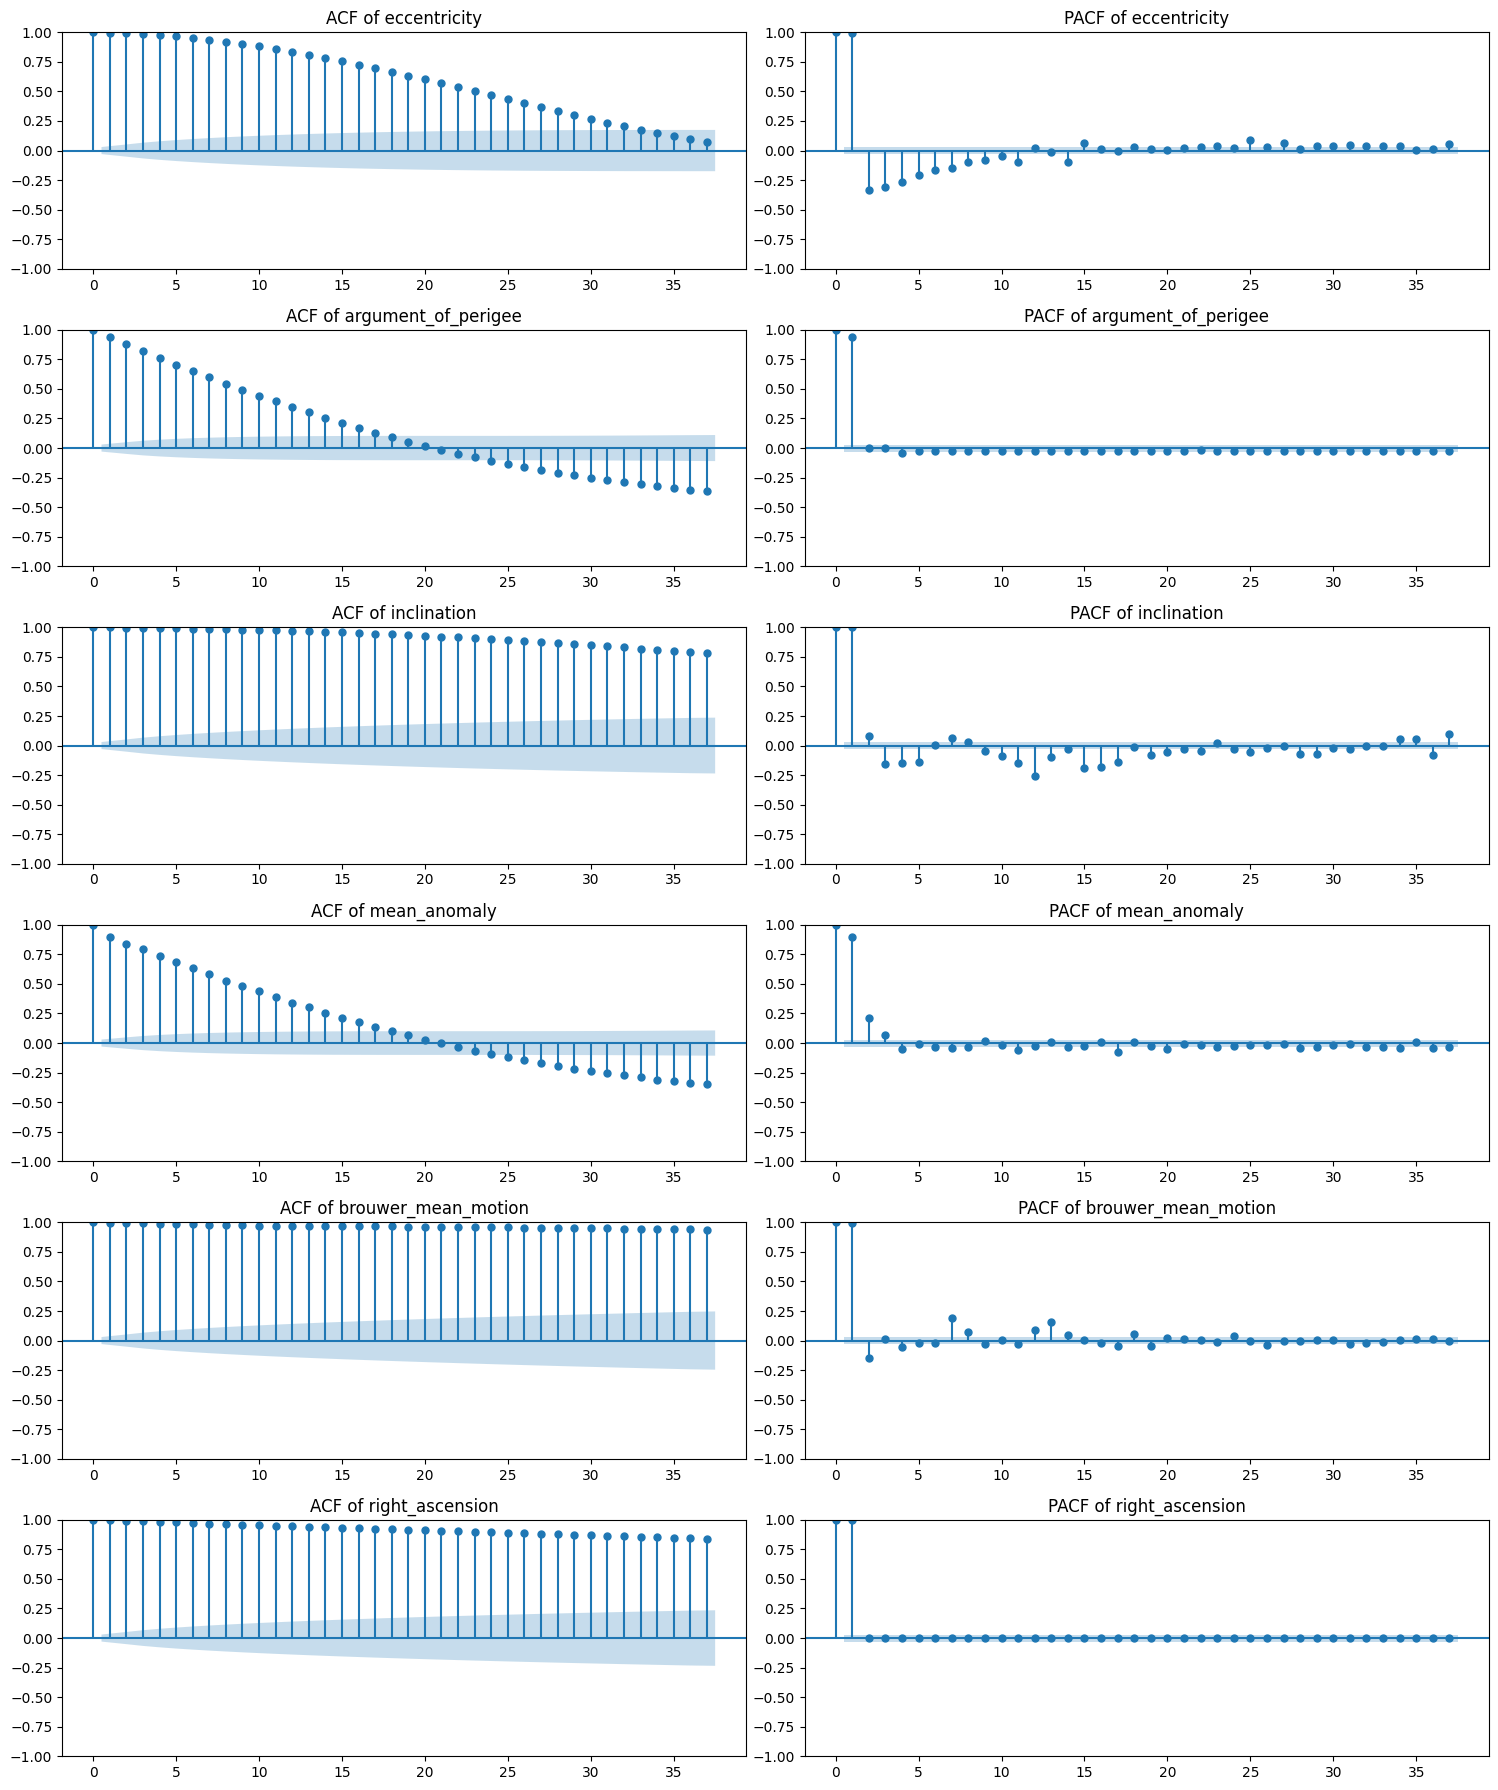

In [54]:
acf_pacf(ja3_tle)

## Stationary Test: ADF Test

In [55]:
adf_test(ja3_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -8.298070e+00
p-value                        4.088556e-13
#Lags Used                     2.200000e+01
Number of Observations Used    2.387000e+03
Critical Value (1%)           -3.433092e+00
Critical Value (5%)           -2.862752e+00
Critical Value (10%)          -2.567415e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic               -3.118712
p-value                           0.025199
#Lags Used                       22.000000
Number of Observations Used    2387.000000
Critical Value (1%)              -3.433092
Critical Value (5%)              -2.862752
Critical Value (10%)             -2.567415

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic               -5.458106
p-value                           0.000003
#Lags Used                       26.000000
Number of Observations Used    2383.000000
Critical Value (1%)              -3.433097
Critical Value (5%)              -2.862

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2410 entries, 2016-01-31 19:27:29.355551 to 2022-10-03 10:55:29.352575
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         2410 non-null   float64
 1   argument_of_perigee  2410 non-null   float64
 2   inclination          2410 non-null   float64
 3   mean_anomaly         2410 non-null   float64
 4   brouwer_mean_motion  2410 non-null   float64
 5   right_ascension      2410 non-null   float64
dtypes: float64(6)
memory usage: 131.8 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   2410.000000          2410.000000  2410.000000   2410.000000   
mean       0.000789             4.713344     1.152634     -4.713325   
std        0.000039             0.048556     0.000029      0.049303   
min        0.000495             4.522810     1.152570     -5.138166   
25%        0.000767             4.676146  

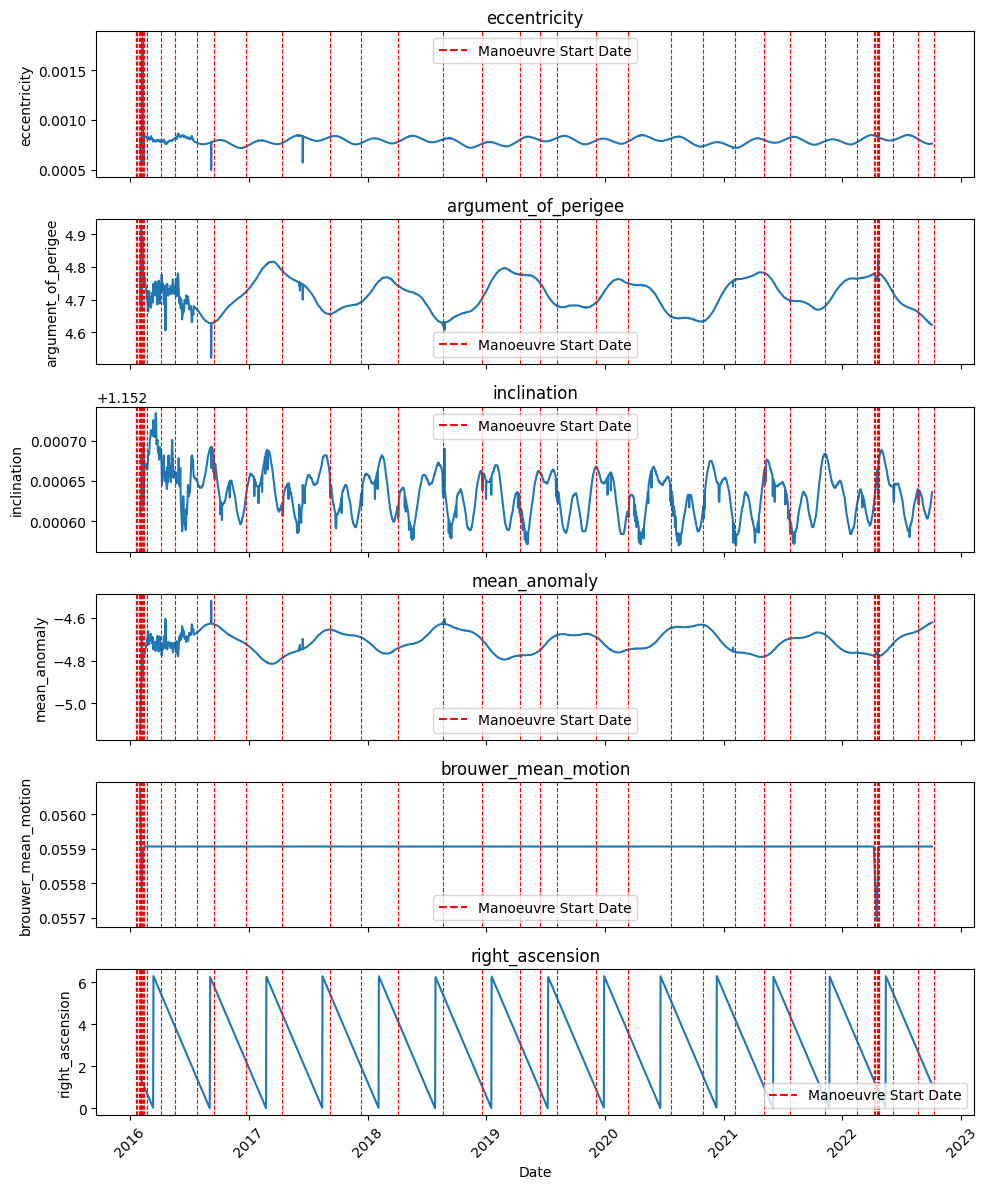

In [56]:
eda(ja3_tle, ja3man)

## Exploratory Data Analysis Filtered

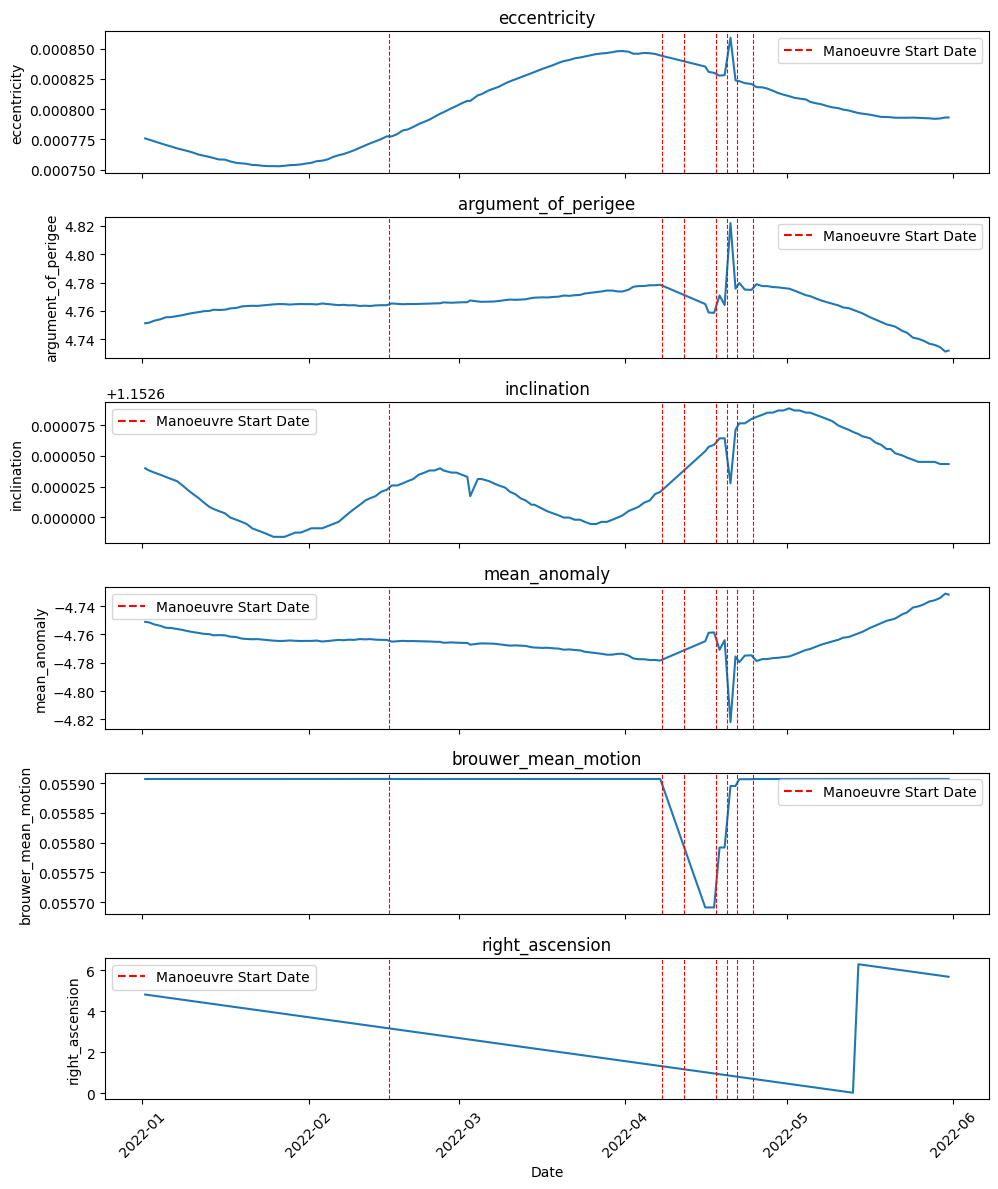

In [57]:
eda_filtered(ja3_tle, ja3man, '2022-01-01', '2022-06-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (3, 0, 2) with MSE: 6.027382060750687e-07


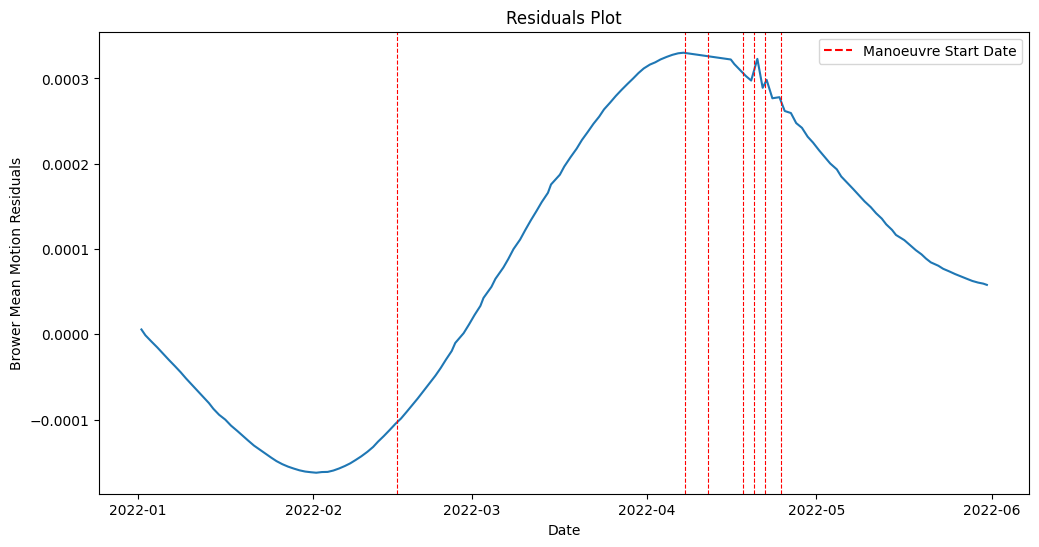

In [58]:
ja3ecc_best_model = best_arima_fit(ja3_tle['eccentricity'])

plot_residuals(ja3ecc_best_model,ja3man, '2022-01-01', '2022-06-01')

### Argument of Perigee

Best ARIMA order: (3, 0, 1) with MSE: 22.21630153837454


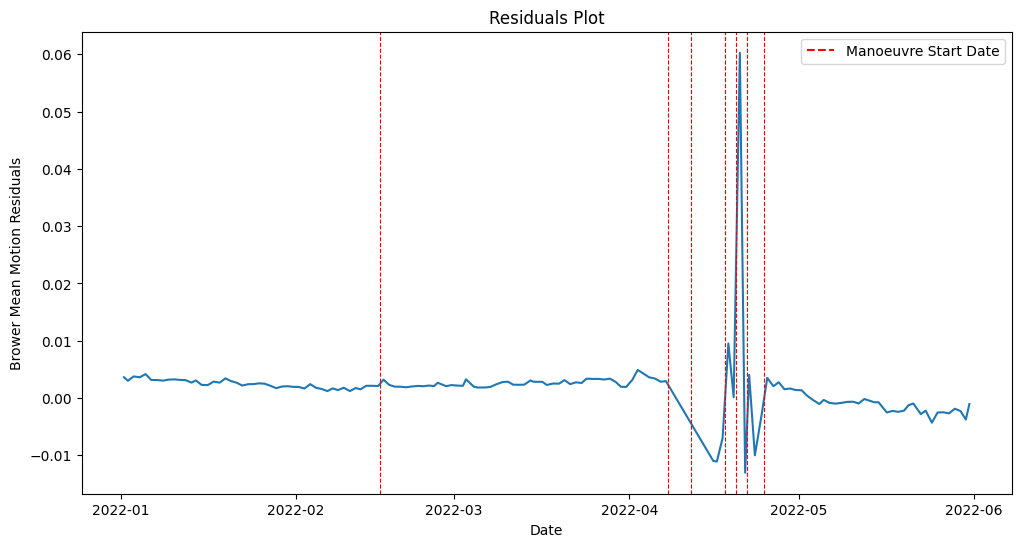

In [59]:
ja3aop_best_model = best_arima_fit(ja3_tle['argument_of_perigee'])

plot_residuals(ja3aop_best_model,ja3man, '2022-01-01', '2022-06-01')

### Inclination


Best ARIMA order: (1, 1, 2) with MSE: 1.3285642464481529


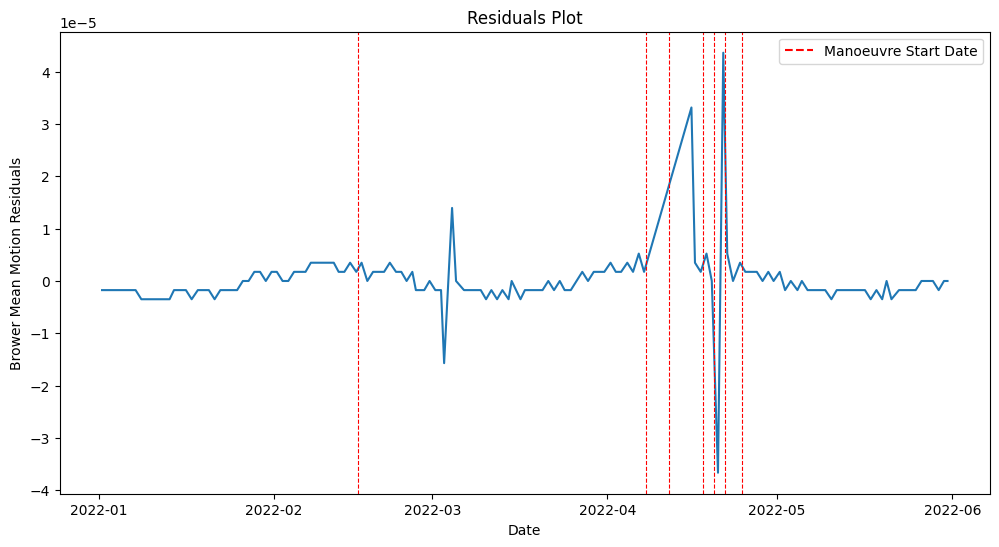

In [60]:
ja3inc_best_model = best_arima_fit(ja3_tle['inclination'])

plot_residuals(ja3inc_best_model,ja3man, '2022-01-01', '2022-06-01')

### Mean Anomaly

Best ARIMA order: (1, 2, 1) with MSE: 22.208840351190222


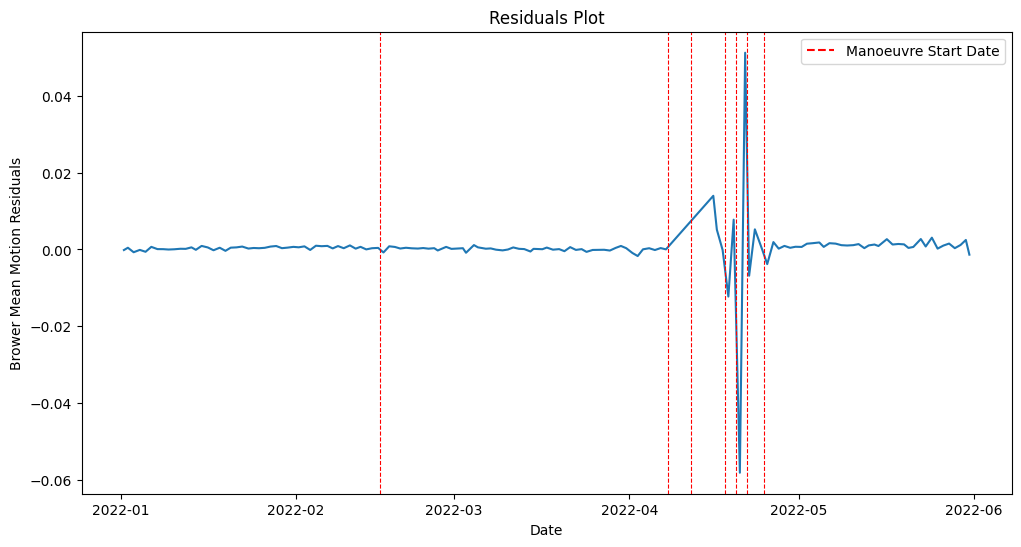

In [61]:
ja3ma_best_model = best_arima_fit(ja3_tle['mean_anomaly'])

plot_residuals(ja3ma_best_model,ja3man, '2022-01-01', '2022-06-01')

### Brouwer Mean Motion

Best ARIMA order: (2, 0, 1) with MSE: 0.0031252806407303505


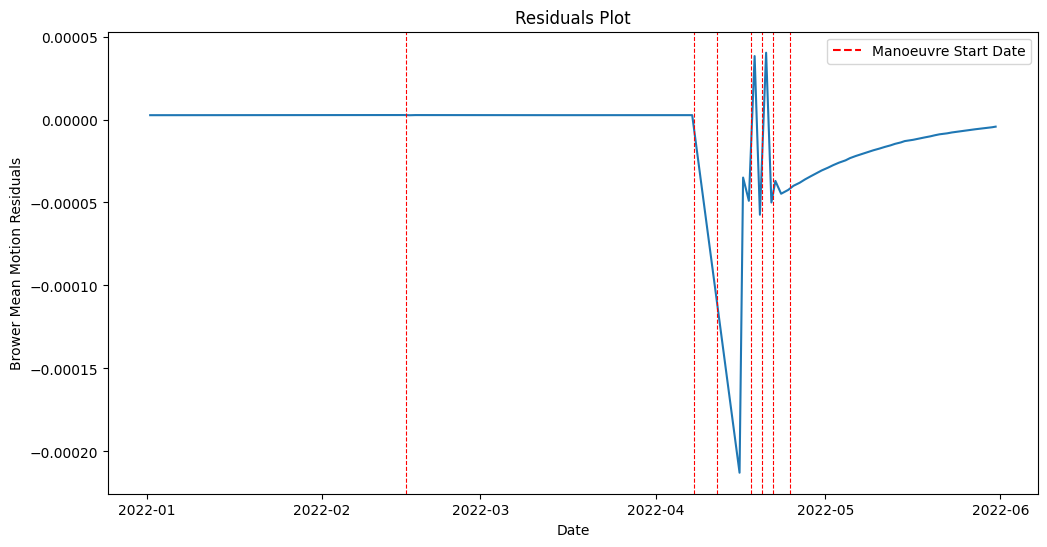

In [62]:
ja3bmm_best_model = best_arima_fit(ja3_tle['brouwer_mean_motion'])

plot_residuals(ja3bmm_best_model,ja3man, '2022-01-01', '2022-06-01')

### Right Ascension

Best ARIMA order: (3, 0, 1) with MSE: 12.898827861786186


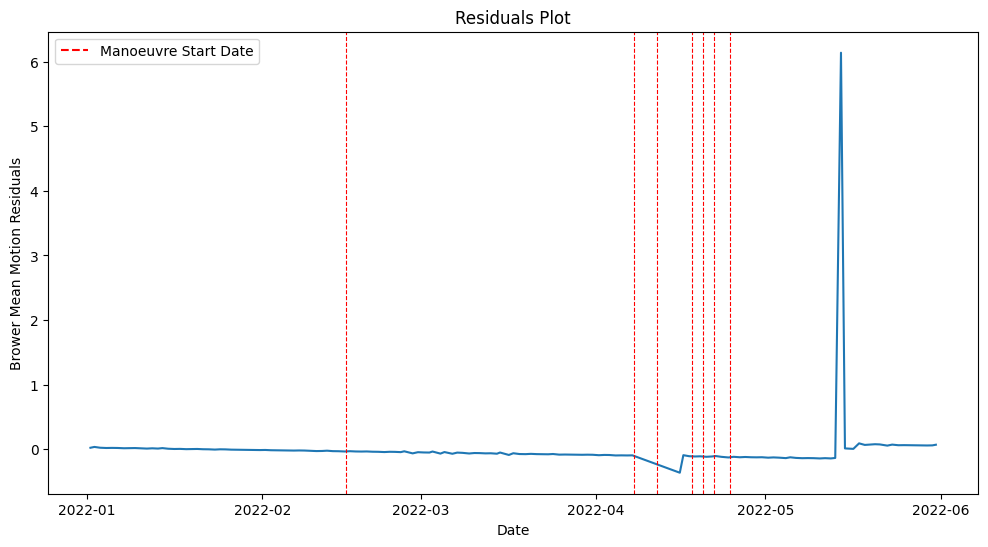

In [63]:
ja3ra_best_model = best_arima_fit(ja3_tle['right_ascension'])

plot_residuals(ja3ra_best_model,ja3man, '2022-01-01', '2022-06-01')

# Sentinel-6A

## Importing Datasets

In [64]:
s6a_tle = read_satellite_data('unpropagated_elements_Sentinel-6A.csv')
s6a_tle.head()

eccentricity  argument of perigee  inclination  \
2020-12-05 10:47:44.799647      0.000582             4.521071     1.152715   
2020-12-06 03:35:09.704831      0.000583             4.516135     1.152715   
2020-12-07 01:58:23.043359      0.000583             4.535687     1.152717   
2020-12-08 02:13:32.505312      0.000582             4.518034     1.152711   
2020-12-09 08:04:30.230399      0.000582             4.518357     1.152717   

                            mean anomaly  Brouwer mean motion  right ascension  
2020-12-05 10:47:44.799647     -4.520406             0.056154         0.179238  
2020-12-06 03:35:09.704831     -4.515516             0.056154         0.153622  
2020-12-07 01:58:23.043359     -4.535093             0.056154         0.119456  
2020-12-08 02:13:32.505312     -4.517410             0.056154         0.082404  
2020-12-09 08:04:30.230399     -4.517710             0.056154         0.036849

In [65]:
s6aman = extract_start_end_dates('s6aman.txt')
s6aman.head()

start_date            end_date
0 2020-11-23 02:38:00 2020-11-23 02:38:00
1 2020-11-23 09:50:00 2020-11-23 09:58:00
2 2020-11-24 01:38:00 2020-11-24 01:42:00
3 2020-11-27 05:22:00 2020-11-27 05:25:00
4 2020-12-10 05:01:00 2020-12-10 05:08:00

## Formatting the Columns

In [66]:
format_cols(s6a_tle)
s6a_tle.head()

eccentricity  argument_of_perigee  inclination  \
2020-12-05 10:47:44.799647      0.000582             4.521071     1.152715   
2020-12-06 03:35:09.704831      0.000583             4.516135     1.152715   
2020-12-07 01:58:23.043359      0.000583             4.535687     1.152717   
2020-12-08 02:13:32.505312      0.000582             4.518034     1.152711   
2020-12-09 08:04:30.230399      0.000582             4.518357     1.152717   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2020-12-05 10:47:44.799647     -4.520406             0.056154         0.179238  
2020-12-06 03:35:09.704831     -4.515516             0.056154         0.153622  
2020-12-07 01:58:23.043359     -4.535093             0.056154         0.119456  
2020-12-08 02:13:32.505312     -4.517410             0.056154         0.082404  
2020-12-09 08:04:30.230399     -4.517710             0.056154         0.036849

## Checking for Duplicates

In [67]:
check_duplicates(s6a_tle)

No duplicates


## Missing Values

In [68]:
missing_values(s6a_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

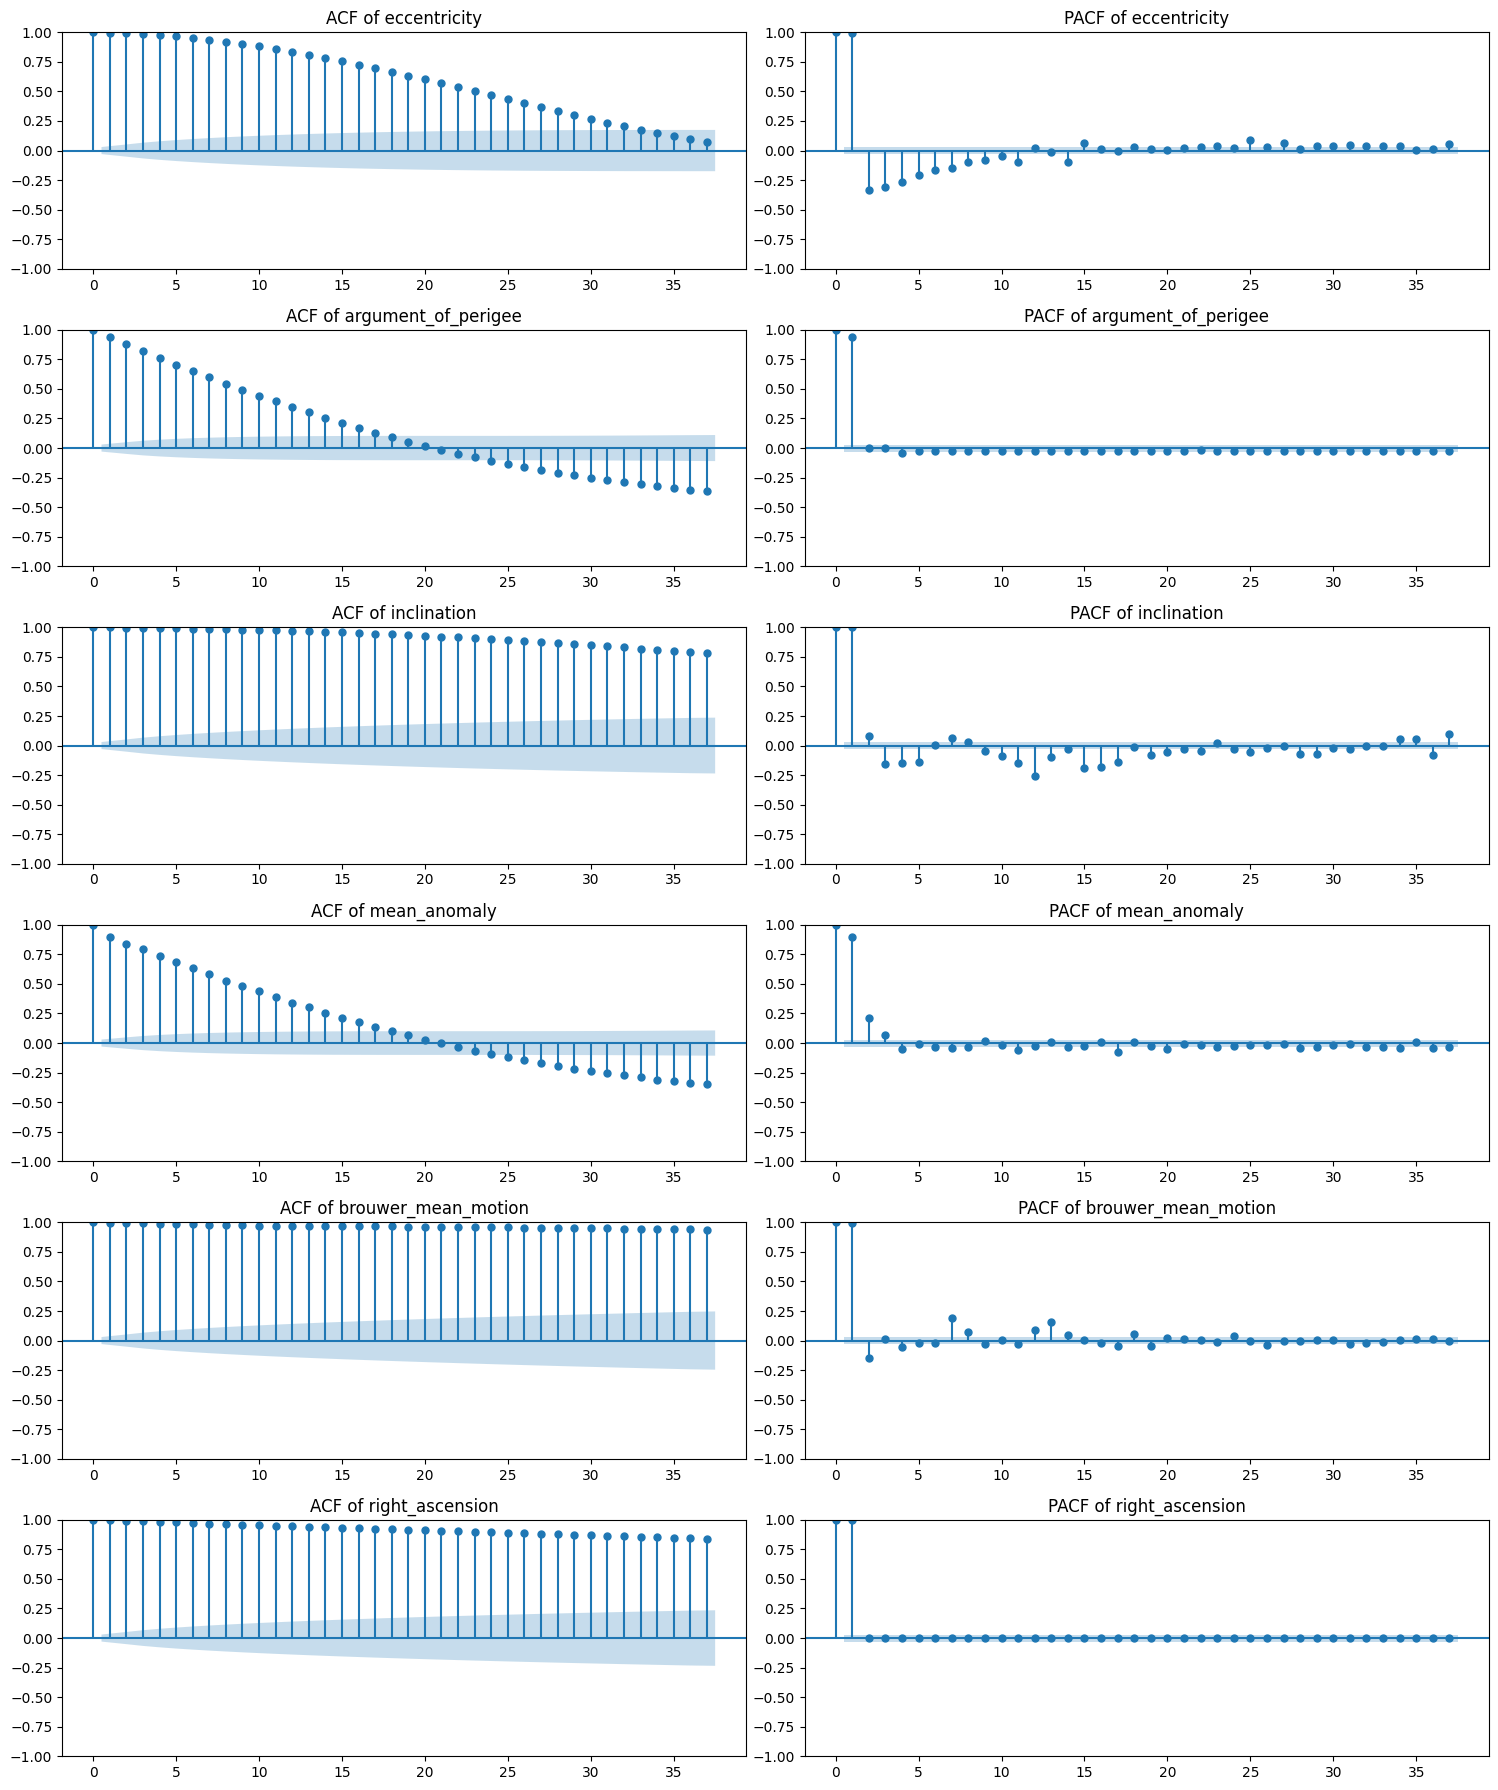

In [69]:
acf_pacf(s6a_tle)

## Stationary Test: ADF Test

In [70]:
adf_test(s6a_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -1.119700e+01
p-value                        2.293303e-20
#Lags Used                     3.000000e+00
Number of Observations Used    6.590000e+02
Critical Value (1%)           -3.440312e+00
Critical Value (5%)           -2.865936e+00
Critical Value (10%)          -2.569111e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -9.954102e+00
p-value                        2.470290e-17
#Lags Used                     5.000000e+00
Number of Observations Used    6.570000e+02
Critical Value (1%)           -3.440342e+00
Critical Value (5%)           -2.865949e+00
Critical Value (10%)          -2.569118e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic              -4.409115
p-value                          0.000286
#Lags Used                      11.000000
Number of Observations Used    651.000000
Critical Value (1%)             -3.440435
Critical Value (5%)             -2.86

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 663 entries, 2020-12-05 10:47:44.799647 to 2022-10-06 09:16:58.628351
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         663 non-null    float64
 1   argument_of_perigee  663 non-null    float64
 2   inclination          663 non-null    float64
 3   mean_anomaly         663 non-null    float64
 4   brouwer_mean_motion  663 non-null    float64
 5   right_ascension      663 non-null    float64
dtypes: float64(6)
memory usage: 36.3 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count    663.000000           663.000000   663.000000    663.000000   
mean       0.000784             4.621659     1.152664     -4.621582   
std        0.000024             0.117674     0.000033      0.117840   
min        0.000575             1.673640     1.152567     -4.879614   
25%        0.000776             4.611174    

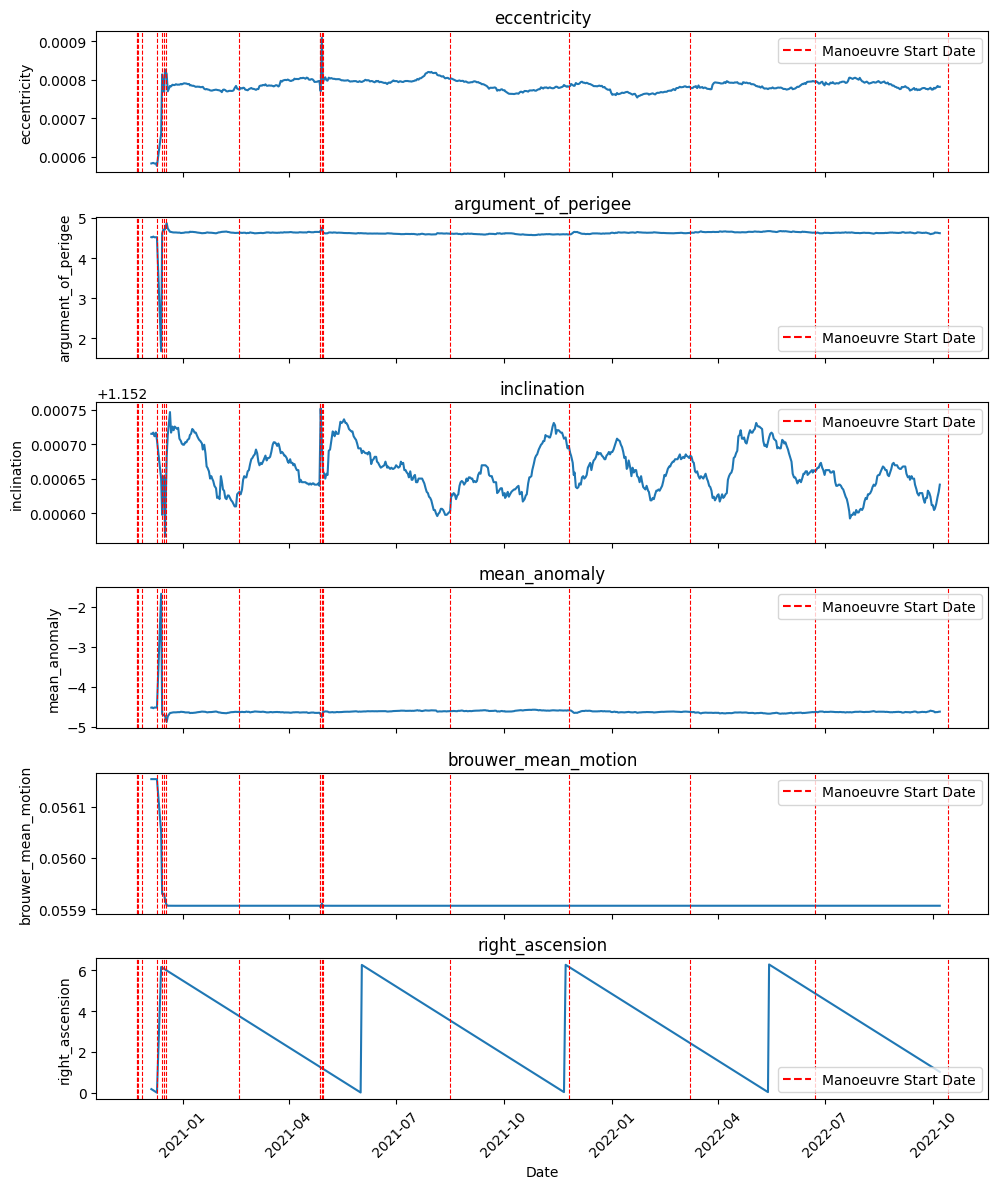

In [71]:
eda(s6a_tle, s6aman)

## Exploratory Data Analysis Filtered

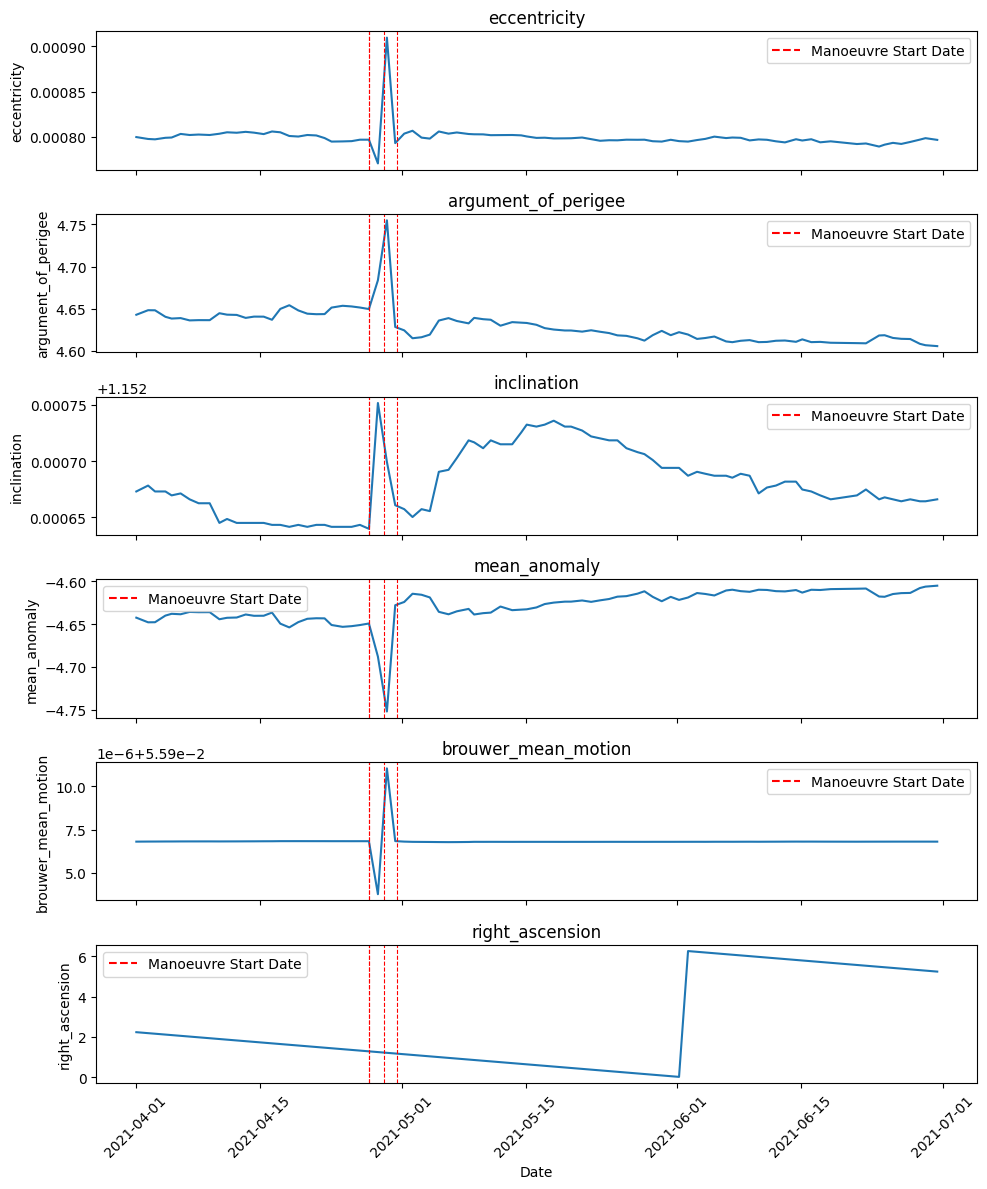

In [72]:
eda_filtered(s6a_tle, s6aman, '2021-04-01', '2021-07-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (2, 1, 0) with MSE: 6.147013768593229e-07


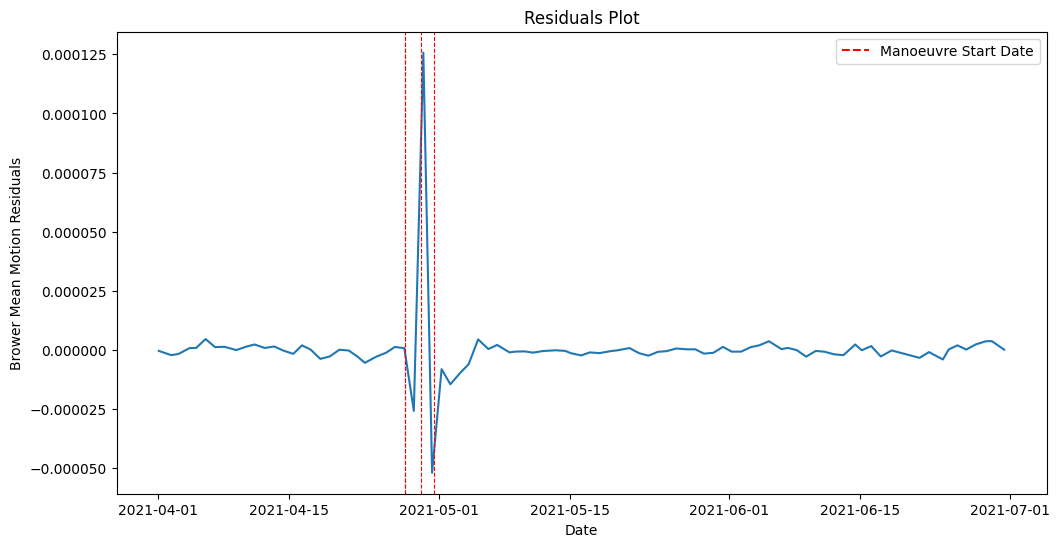

In [73]:
s6aecc_best_model = best_arima_fit(s6a_tle['eccentricity'])

plot_residuals(s6aecc_best_model,s6aman, '2021-04-01', '2021-07-01')

### Argument of Perigee

Best ARIMA order: (2, 1, 0) with MSE: 6.147013768593229e-07


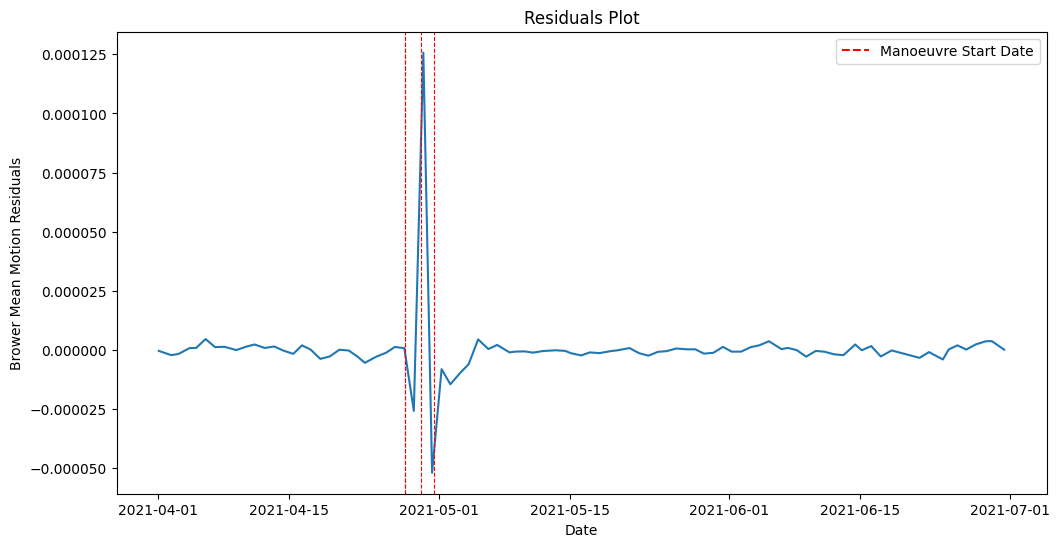

In [74]:
s6aecc_best_model = best_arima_fit(s6a_tle['eccentricity'])

plot_residuals(s6aecc_best_model,s6aman, '2021-04-01', '2021-07-01')

### Inclination

Best ARIMA order: (2, 0, 1) with MSE: 1.3286204775794501


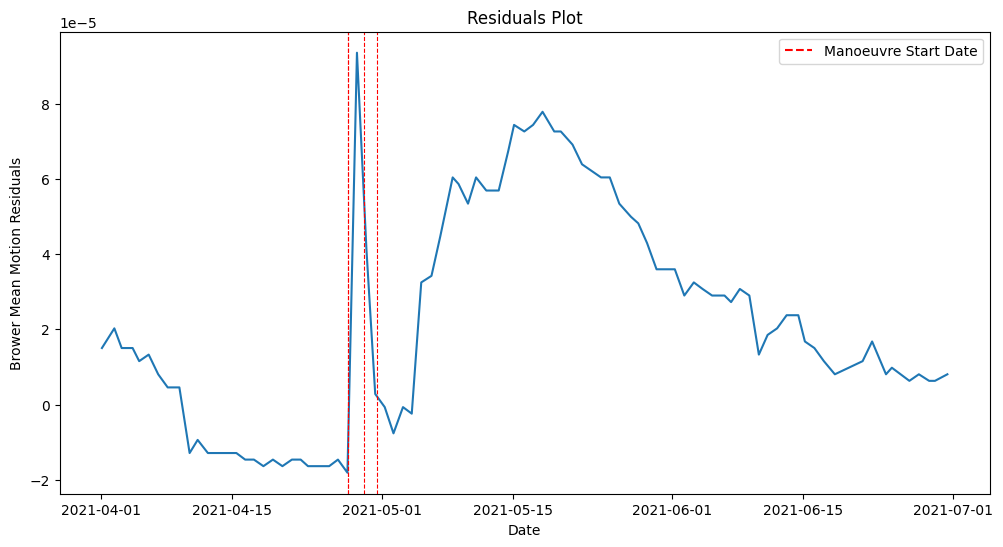

In [75]:
s6ainc_best_model = best_arima_fit(s6a_tle['inclination'])

plot_residuals(s6ainc_best_model,s6aman, '2021-04-01', '2021-07-01')

### Mean Anomaly


Best ARIMA order: (3, 1, 1) with MSE: 21.295729854838857


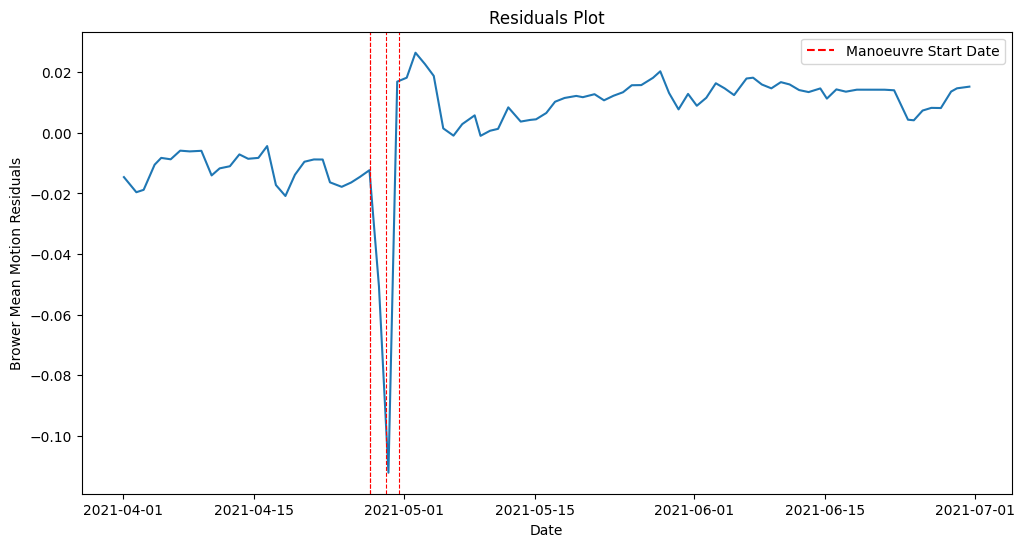

In [76]:
s6ama_best_model = best_arima_fit(s6a_tle['mean_anomaly'])

plot_residuals(s6ama_best_model,s6aman, '2021-04-01', '2021-07-01')

### Brouwer Mean Motion


Best ARIMA order: (2, 2, 0) with MSE: 0.003125776367201901


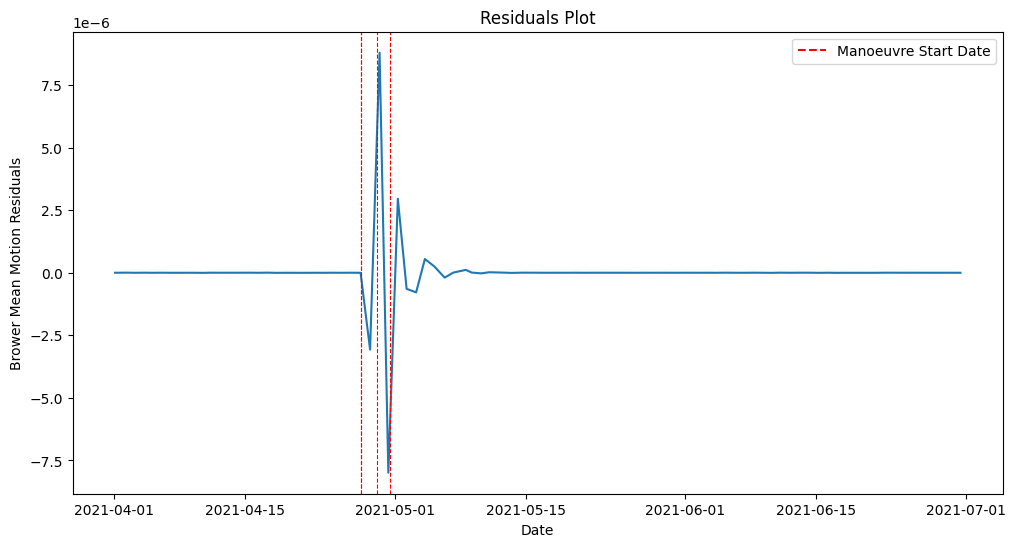

In [77]:
s6abmm_best_model = best_arima_fit(s6a_tle['brouwer_mean_motion'])

plot_residuals(s6abmm_best_model,s6aman, '2021-04-01', '2021-07-01')

### Right Ascension

Best ARIMA order: (1, 0, 0) with MSE: 13.1367109404748


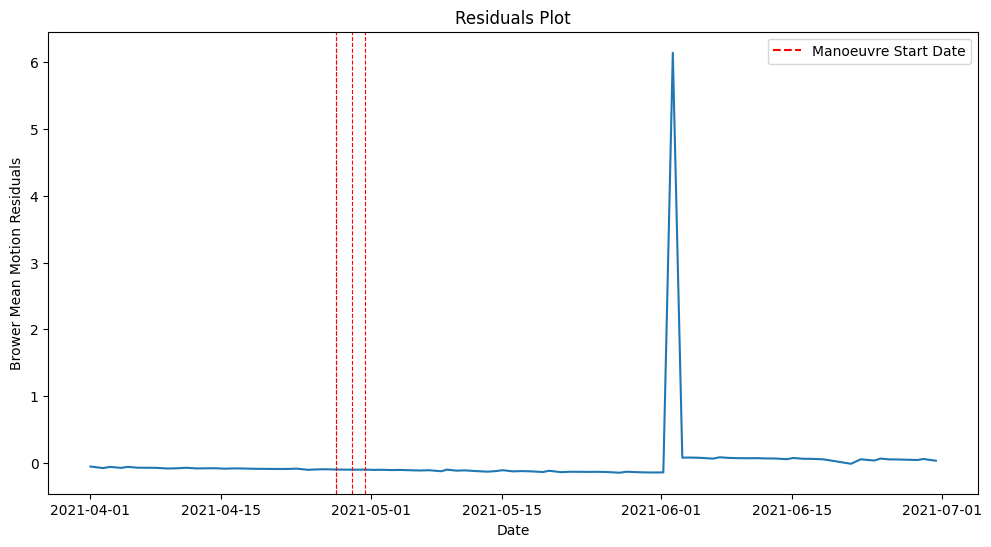

In [78]:
s6ara_best_model = best_arima_fit(s6a_tle['right_ascension'])

plot_residuals(s6ara_best_model,s6aman, '2021-04-01', '2021-07-01')

# SARAL

## Importing Datasets

In [79]:
srl_tle = read_satellite_data('unpropagated_elements_SARAL.csv')
srl_tle.head()

eccentricity  argument of perigee  inclination  \
2013-03-10 13:13:33.964320      0.000129             3.342279     1.719596   
2013-03-11 22:45:10.058975      0.000130             3.291112     1.719589   
2013-03-13 01:34:26.835167      0.000151             3.208097     1.719577   
2013-03-14 02:43:30.192095      0.000527             1.514363     1.719552   
2013-03-15 18:57:49.375584      0.000076             2.181199     1.719575   

                            mean anomaly  Brouwer mean motion  right ascension  
2013-03-10 13:13:33.964320     -3.340260             0.062543         4.532454  
2013-03-11 22:45:10.058975     -3.289068             0.062543         4.556435  
2013-03-13 01:34:26.835167     -3.206336             0.062543         4.575627  
2013-03-14 02:43:30.192095     -1.510258             0.062525         4.593694  
2013-03-15 18:57:49.375584     -2.179016             0.062531         4.622396

In [80]:
srlman = extract_start_end_dates('srlman.txt')
srlman.head()

start_date            end_date
0 2013-02-27 13:14:00 2013-02-27 13:19:00
1 2013-02-27 14:58:00 2013-02-27 15:04:00
2 2013-03-01 15:51:00 2013-03-01 15:53:00
3 2013-03-02 06:03:00 2013-03-02 06:05:00
4 2013-03-03 02:10:00 2013-03-03 02:12:00

## Formatting the Columns

In [81]:
format_cols(srl_tle)
srl_tle.head()

eccentricity  argument_of_perigee  inclination  \
2013-03-10 13:13:33.964320      0.000129             3.342279     1.719596   
2013-03-11 22:45:10.058975      0.000130             3.291112     1.719589   
2013-03-13 01:34:26.835167      0.000151             3.208097     1.719577   
2013-03-14 02:43:30.192095      0.000527             1.514363     1.719552   
2013-03-15 18:57:49.375584      0.000076             2.181199     1.719575   

                            mean_anomaly  brouwer_mean_motion  right_ascension  
2013-03-10 13:13:33.964320     -3.340260             0.062543         4.532454  
2013-03-11 22:45:10.058975     -3.289068             0.062543         4.556435  
2013-03-13 01:34:26.835167     -3.206336             0.062543         4.575627  
2013-03-14 02:43:30.192095     -1.510258             0.062525         4.593694  
2013-03-15 18:57:49.375584     -2.179016             0.062531         4.622396

## Checking for Duplicates

In [82]:
check_duplicates(srl_tle)

No duplicates


## Missing Values

In [83]:
missing_values(srl_tle)

Percentage of missing value in entire dataset is: 0.0%


## ACF and PACF Plots

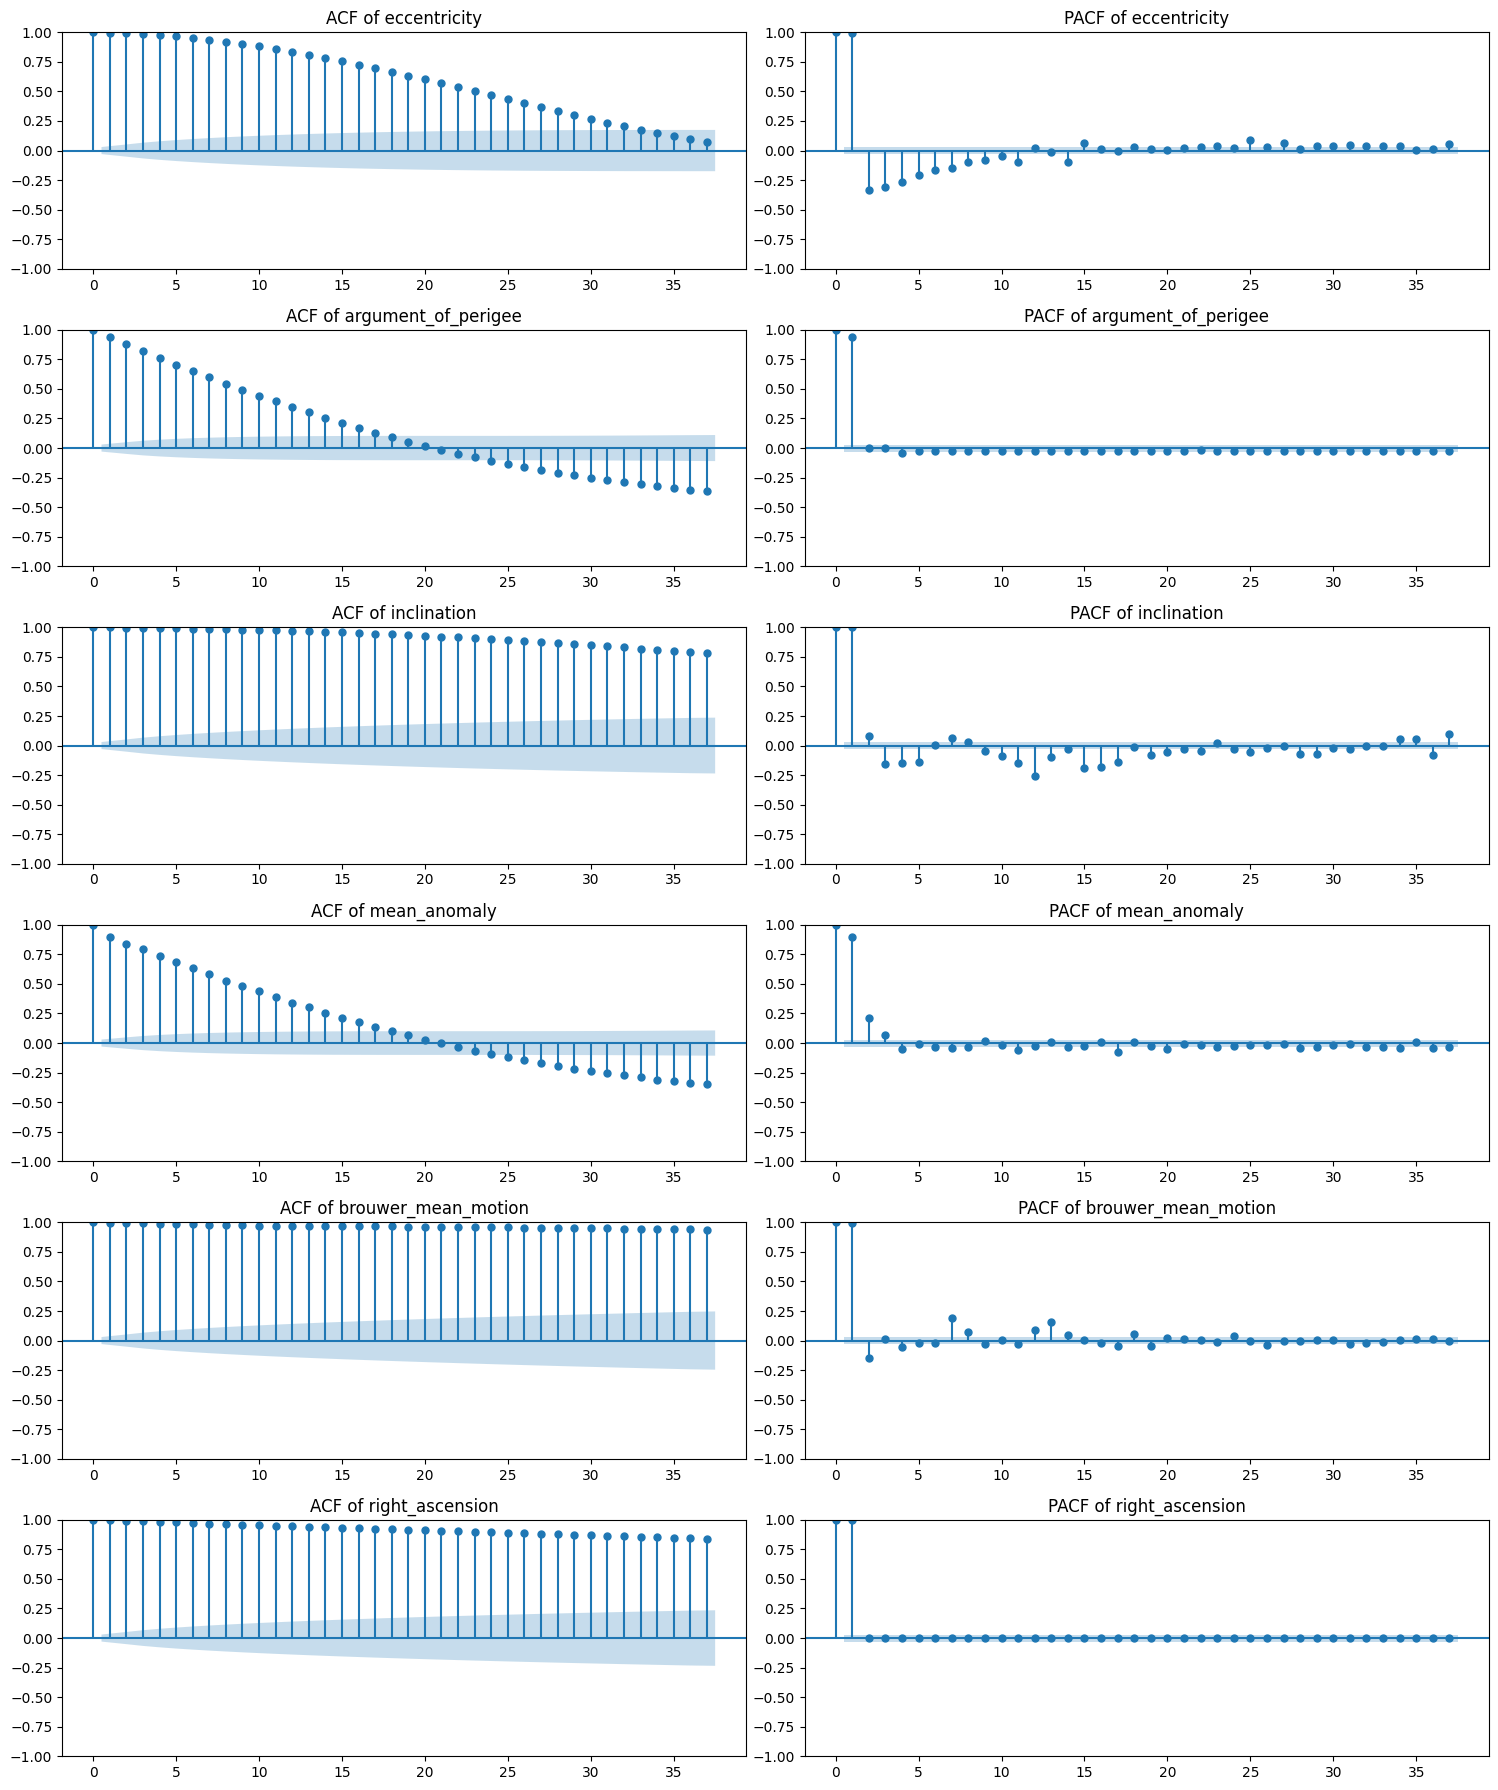

In [84]:
acf_pacf(srl_tle)

## Stationary Test: ADF Test

In [85]:
adf_test(srl_tle)

Augmented Dickey-Fuller Test: eccentricity
ADF Test Statistic            -1.272019e+01
p-value                        9.865744e-24
#Lags Used                     2.500000e+01
Number of Observations Used    3.264000e+03
Critical Value (1%)           -3.432355e+00
Critical Value (5%)           -2.862426e+00
Critical Value (10%)          -2.567242e+00

Augmented Dickey-Fuller Test: argument_of_perigee
ADF Test Statistic            -1.088801e+01
p-value                        1.245687e-19
#Lags Used                     2.500000e+01
Number of Observations Used    3.264000e+03
Critical Value (1%)           -3.432355e+00
Critical Value (5%)           -2.862426e+00
Critical Value (10%)          -2.567242e+00

Augmented Dickey-Fuller Test: inclination
ADF Test Statistic               -5.535019
p-value                           0.000002
#Lags Used                       29.000000
Number of Observations Used    3260.000000
Critical Value (1%)              -3.432358
Critical Value (5%)             

## Exploratory Data Analysis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3290 entries, 2013-03-10 13:13:33.964320 to 2022-09-14 04:39:56.791584
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   eccentricity         3290 non-null   float64
 1   argument_of_perigee  3290 non-null   float64
 2   inclination          3290 non-null   float64
 3   mean_anomaly         3290 non-null   float64
 4   brouwer_mean_motion  3290 non-null   float64
 5   right_ascension      3290 non-null   float64
dtypes: float64(6)
memory usage: 179.9 KB
None
       eccentricity  argument_of_perigee  inclination  mean_anomaly  \
count   3290.000000          3290.000000  3290.000000   3290.000000   
mean       0.000143             1.555963     1.719883     -1.553658   
std        0.000064             0.667961     0.000082      0.667959   
min        0.000002             0.157865     1.719540     -4.476841   
25%        0.000092             0.997294  

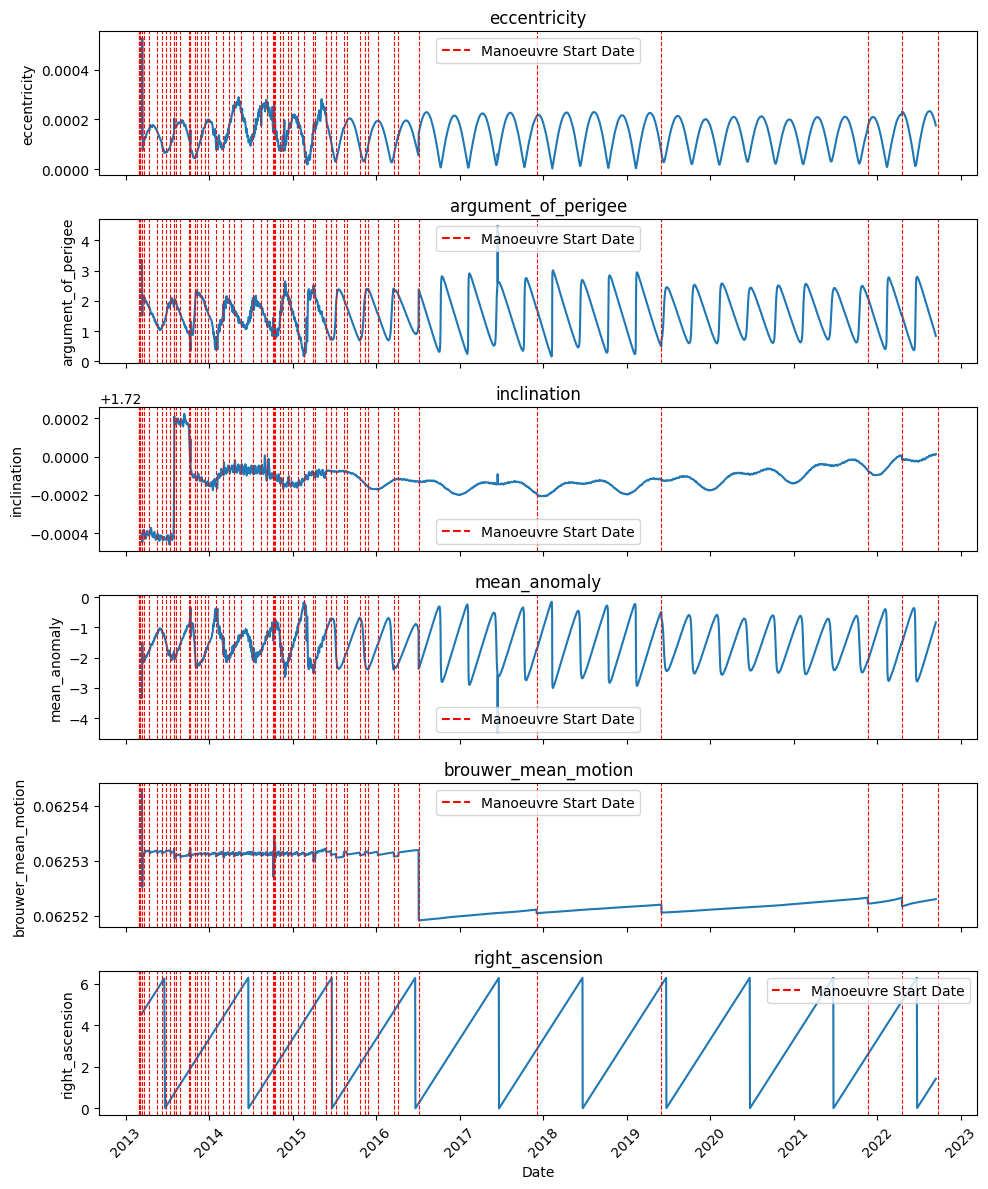

In [86]:
eda(srl_tle, srlman)

## Exploratory Data Analysis Filtered

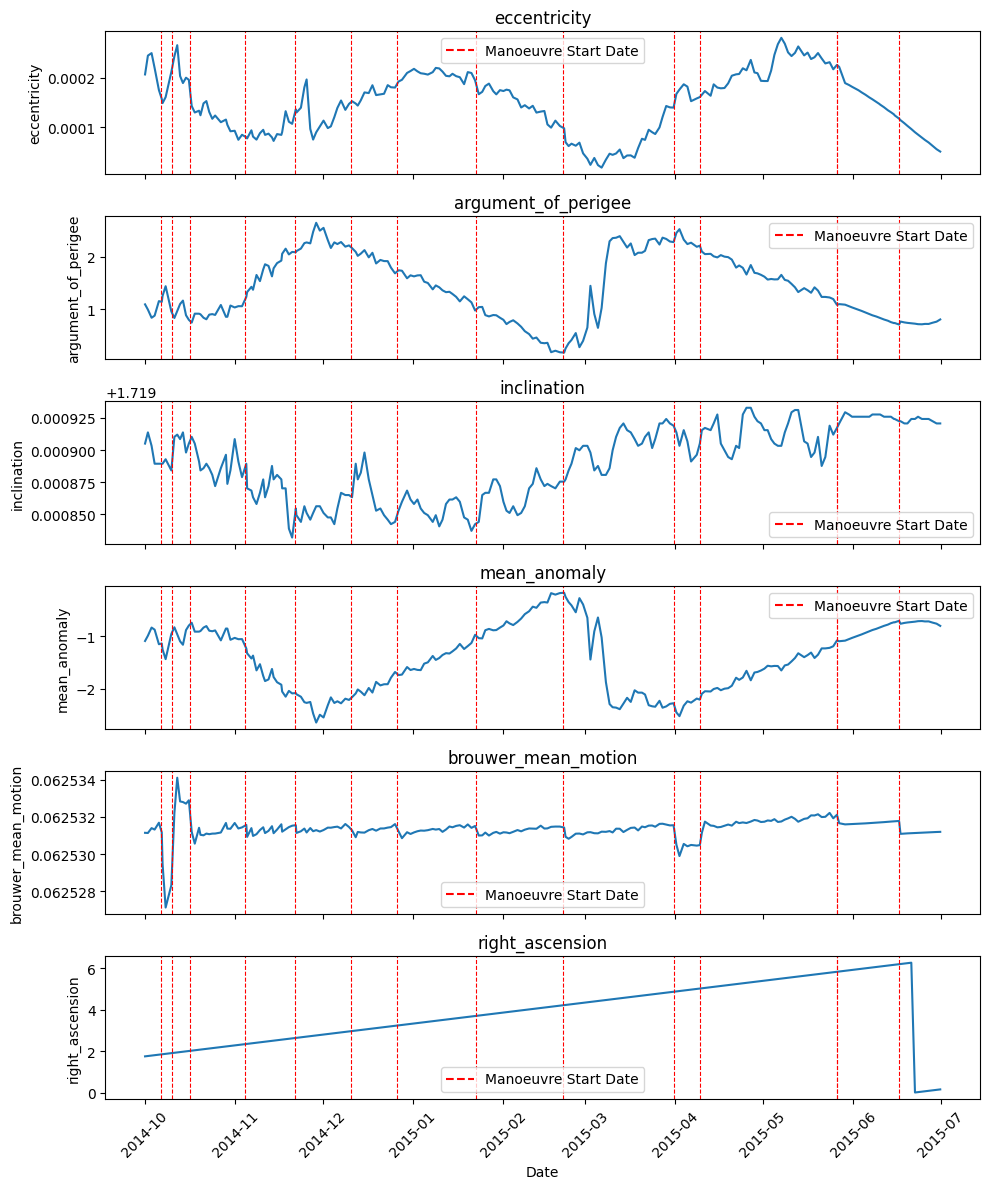

In [87]:
eda_filtered(srl_tle, srlman, '2014-10-01', '2015-07-01')

## ARIMA Model and Plotting Residuals

### Eccentricity

Best ARIMA order: (1, 0, 0) with MSE: 2.441570770948574e-08


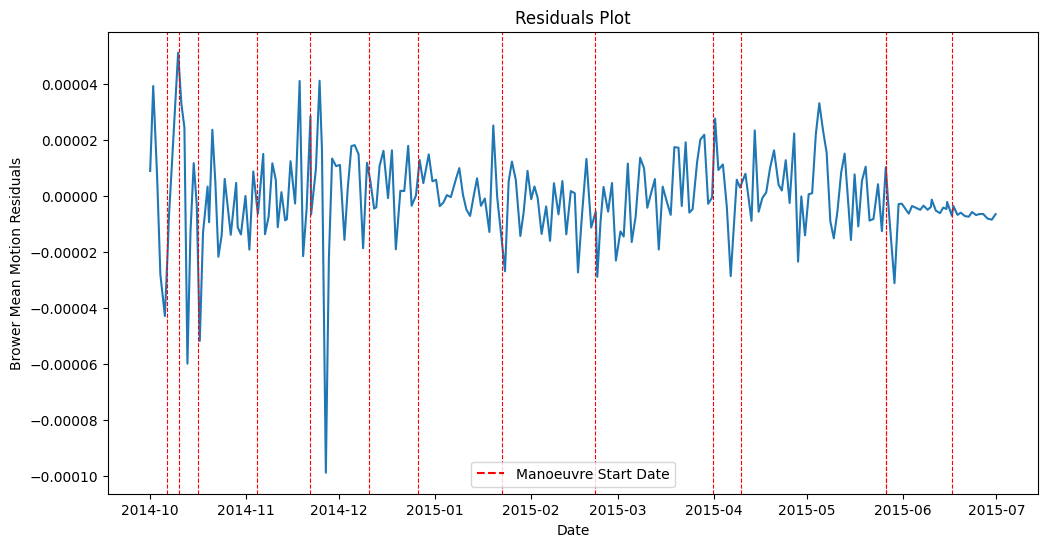

In [88]:
srlecc_best_model = best_arima_fit(srl_tle['eccentricity'])

plot_residuals(srlecc_best_model,srlman, '2014-10-01', '2015-07-01')

### Argument of Perigee

Best ARIMA order: (1, 0, 0) with MSE: 2.8526444434611142


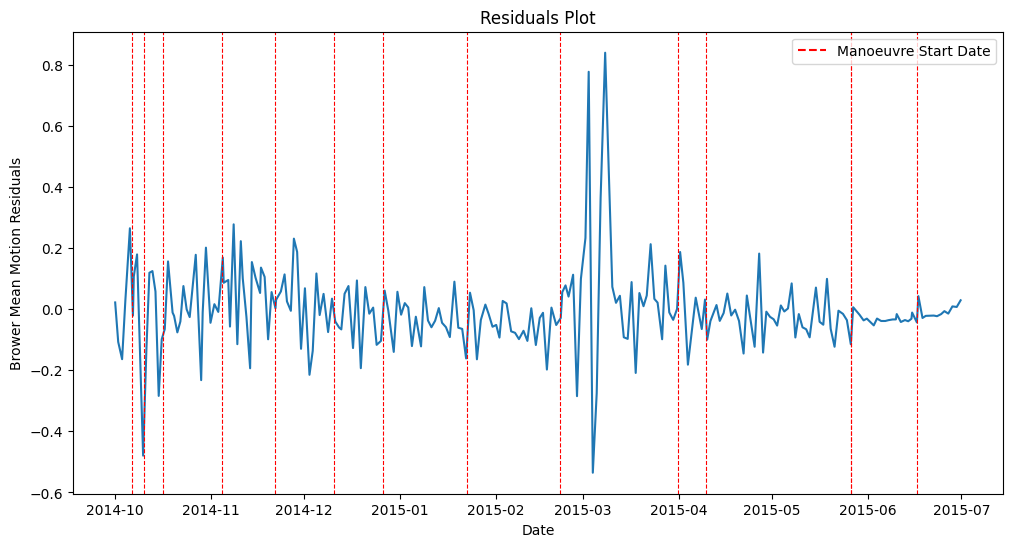

In [89]:
srlaop_best_model = best_arima_fit(srl_tle['argument_of_perigee'])

plot_residuals(srlaop_best_model,srlman, '2014-10-01', '2015-07-01')

### Inclination


Best ARIMA order: (1, 0, 0) with MSE: 2.9579982312929536


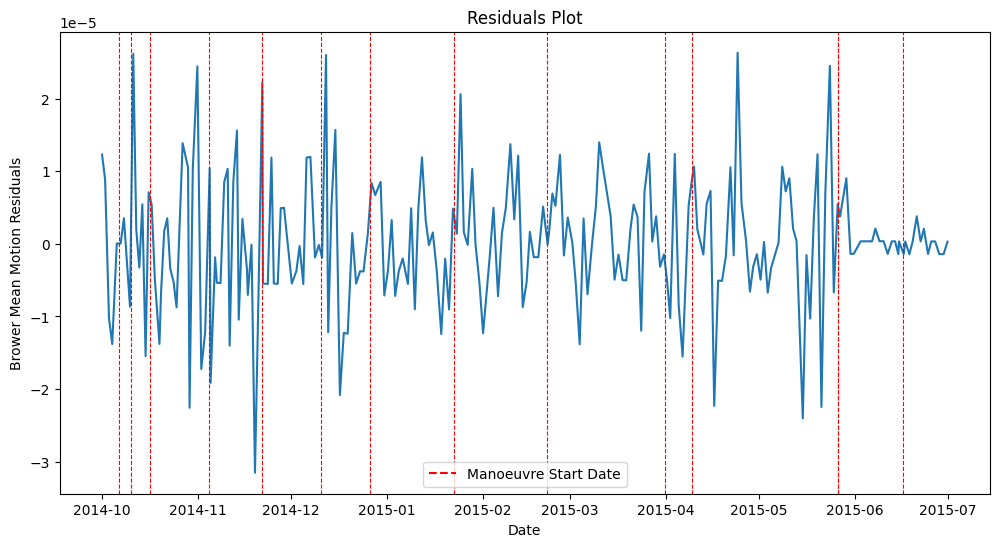

In [90]:
srlinc_best_model = best_arima_fit(srl_tle['inclination'])

plot_residuals(srlinc_best_model,srlman, '2014-10-01', '2015-07-01')

### Mean Anomaly


Best ARIMA order: (2, 0, 1) with MSE: 2.816264139803997


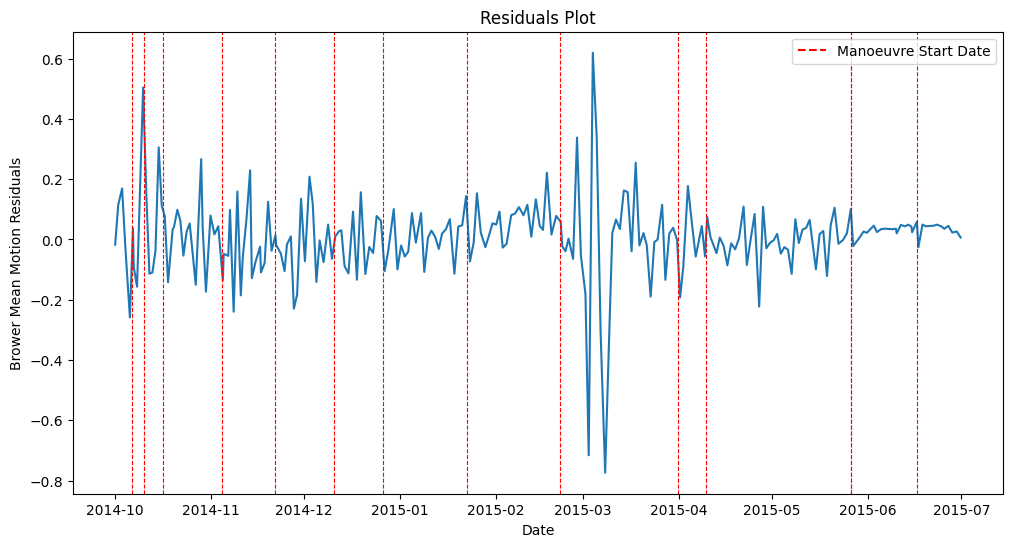

In [91]:
srlma_best_model = best_arima_fit(srl_tle['mean_anomaly'])

plot_residuals(srlma_best_model,srlman, '2014-10-01', '2015-07-01')

### Brouwer Mean Motion


Best ARIMA order: (1, 2, 2) with MSE: 0.0039093218714396525


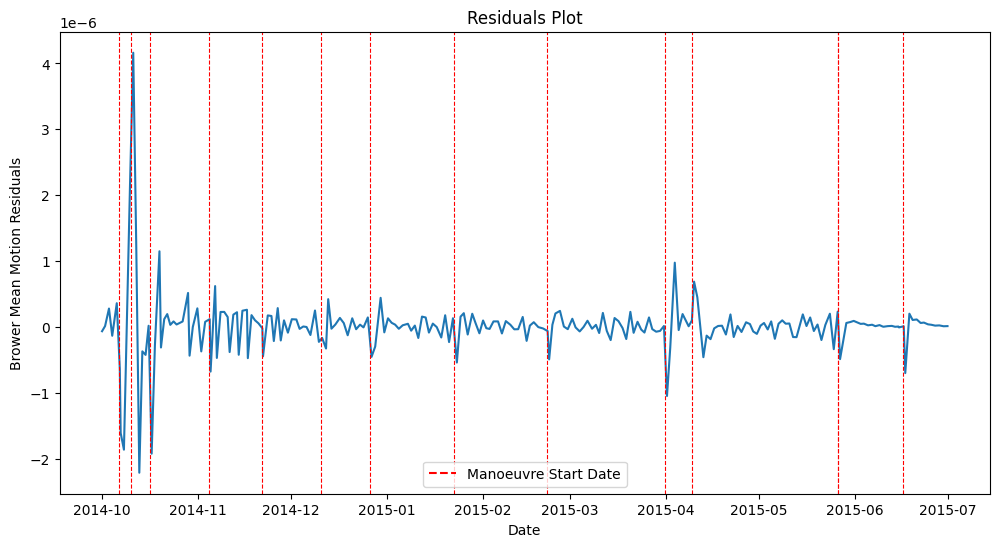

In [92]:
srlbmm_best_model = best_arima_fit(srl_tle['brouwer_mean_motion'])

plot_residuals(srlbmm_best_model,srlman, '2014-10-01', '2015-07-01')

### Right Ascension

Best ARIMA order: (2, 0, 2) with MSE: 13.15846195259364


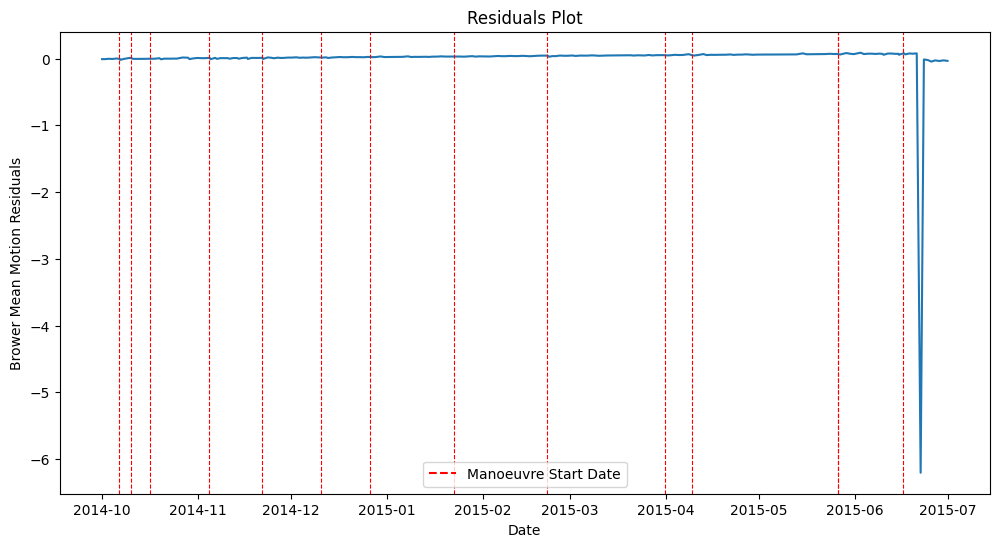

In [93]:
srlra_best_model = best_arima_fit(srl_tle['right_ascension'])

plot_residuals(srlra_best_model,srlman, '2014-10-01', '2015-07-01')